<a href="https://colab.research.google.com/github/deep1003/deep1003/blob/master/ai_patent_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [322]:
# Colab 단축키
# Ctrl + S (저장)
# Ctrl + Enter (셀하나 실행)
# Ctrl + Shift + Enter (선택한 코드만 실행)
# Ctrl + F9 (전체실행)
# Ctrl + F8 (현재 셀 포함 이전 전체 실행)
# Ctrl + F10 (현재 셀 포함 이후 전체 실행)
# Ctrl + / (전체 주석처리 & 해제)

In [323]:
# 필요한 패키지 설치 (최초 한 번만)
!pip install pandas numpy networkx matplotlib python-louvain pyvis pycountry rapidfuzz adjustText

In [324]:
# 1. Google Drive 마운트 (파일 읽고/쓰기 위해서)
from google.colab import drive
drive.mount('/content/drive') # (구글 드라이브 설치후 보통 G:\ 를 의미함)

# 2. 데이터 디렉토리 경로 설정
base_dir = '/content/drive/MyDrive/data1' # (실제 csv 파일이 있는 위치)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [325]:
# Ctrl + F10를 하면 이 셀부터 전체 실행 -> 더 많은 단축키는 상단에 Runtime 클릭
import pandas as pd            # "Python Data Analysis Library" 표 데이터 처리
import matplotlib.pyplot as plt  # "MATLAB‑style plotting" 2D 시각화
import networkx as nx          # "NetworkX" 네트워크 분석
import numpy as np             # "Numerical Python" 수치 계산
import seaborn as sns          # "Seaborn" 통계 시각화
import pycountry               # "pycountry" ISO 국가 코드

In [447]:
# 셀 1: Google Drive에서 CSV 파일 목록 조회 및 필터링

import os # Operating System 약어: 운영체제 기능(경로·환경 변수) 제어
from glob import glob # glob(“global”) 파일패턴검색

base_dir = '/content/drive/My Drive/data1'  # 데이터폴더경로

# '36','37',... 등으로 시작하는 파일만 골라내기 위한 접두사(tuple)
prefixes = ('43','44')

# base_dir 하위의 모든 .csv 파일 경로를 리스트로 수집
all_csv = glob(os.path.join(base_dir, '*.csv'))
# os.path.join: 경로 결합

# 수집된 파일 중 basename(파일명) 기준으로 prefixes 중 하나로 시작하는 파일만 필터링
csv_files = [
    f for f in all_csv
    if os.path.basename(f).startswith(prefixes)
]

# 찾은 파일 개수 및 파일명 출력
print(f'찾은 파일 {len(csv_files)}개:')
for f in csv_files:
    print('  -', os.path.basename(f))


찾은 파일 2개:
  - 43.Semantics.csv
  - 44.SentimentAnalysis.csv


In [448]:
# 셀 2: CSV 파일 읽기 및 중복 제거
import pandas as pd   # 데이터 처리용 pandas 불러오기

df_list = []  # 개별 CSV DataFrame을 담을 리스트

# 각 파일별로 여러 인코딩 시도하면서 읽기
for f in csv_files:
    for enc in ('utf-8', 'cp949', 'latin1'):
        try:
            # 지정된 인코딩으로 CSV 읽기
            df = pd.read_csv(f, encoding=enc)
            print(f'{os.path.basename(f)} 읽기 성공 (encoding={enc})')
            df_list.append(df)  # 읽은 DataFrame을 리스트에 추가
            break               # 성공 시 다음 파일로
        except Exception:
            continue            # 실패하면 다음 인코딩 시도

# 리스트에 모인 DataFrame을 하나로 합치고 완전 중복 행 제거
combined_df = pd.concat(df_list, ignore_index=True).drop_duplicates()
print(f'▶︎ 병합 후 총 행 수: {len(combined_df)}')


43.Semantics.csv 읽기 성공 (encoding=cp949)
44.SentimentAnalysis.csv 읽기 성공 (encoding=cp949)
▶︎ 병합 후 총 행 수: 1861


In [449]:
combined_df.shape  # DataFrame 행·열 개수

(1861, 45)

In [450]:
combined_df.info()  # DataFrame Column, Non-Null Count, Data Type(문자/숫자)

<class 'pandas.core.frame.DataFrame'>
Index: 1861 entries, 0 to 1868
Data columns (total 45 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   국가코드                        1861 non-null   object
 1   DB종류                        1861 non-null   object
 2   특허/실용 구분                    1861 non-null   object
 3   문헌종류 코드                     1861 non-null   object
 4   발명의 명칭                      1861 non-null   object
 5   발명의 명칭-번역문                  1828 non-null   object
 6   요약                          1861 non-null   object
 7   요약-번역문                      1828 non-null   object
 8   대표청구항                       1861 non-null   object
 9   대표청구항-번역문                   1828 non-null   object
 10  독립청구항[KR,JP,US,CN,EP,IN]    1861 non-null   object
 11  독립청구항-번역문[JP,US,CN,EP]      1828 non-null   object
 12  청구항 수                       1861 non-null   int64 
 13  출원번호                        1861 non-null   object
 1

In [451]:
# 셀 3: 컬럼명 매핑 (한글 → 영문)
import pandas as pd  # pandas 데이터프레임 활용

# 1) combined_df1에 컬럼명 매핑 적용
orig = combined_df.columns.tolist()  # 기존 컬럼명 목록
# 영문 컬럼명 리스트와 원래 한글명 매핑
new = [
  "PTO_id",                # 국가코드
  "PTO_type",              # DB종류
  "patent_kind",           # 특허/실용 구분
  "pub_type_code",         # 문헌종류 코드
  "title",                 # 발명의 명칭
  "title_en",              # 발명의 명칭-번역문
  "abstract",              # 요약
  "abstract_en",           # 요약-번역문
  "claim_main",            # 대표청구항
  "claim_main_en",         # 대표청구항-번역문
  "claims_indep",          # 독립청구항[KR,JP,US,CN,EP,IN]
  "claims_indep_en",       # 독립청구항-번역문[JP,US,CN,EP]
  "num_claims",            # 청구항 수
  "appl_id",               # 출원번호
  "appl_date",             # 출원일
  "pub_id",                # 공개번호
  "pub_date",               # 공개일
  "grant_id",               # 등록번호
  "grant_date",             # 등록일
  "applicant",              # 출원인
  "inventor",               # 발명자
  "citations_count",        # 인용 문헌 수(B1)
  "citation_ids",           # 인용 문헌번호(B1)
  "cited_by_count",         # 피인용 문헌 수(F1)
  "cited_by_ids",           # 피인용 문헌번호(F1)
  "wips_family_id",         # WIPS패밀리 ID
  "wips_family_pub_ids",   # WIPS패밀리 문헌번호(출원기준)
  "wips_family_pub_count", # WIPS패밀리 문헌 수(출원기준)
  "status_info",           # 상태정보[KR,JP,US,EP,CN,CA,AU]
  "current_owner",         # 현재권리자[KR,JP,US,CN,CA,AU]
  "num_applicants",        # 출원인 수
  "applicant_nat",         # 출원인 국적
  "applicant_main_code",   # 출원인 대표명화 코드
  "applicant_main_name_en",# 출원인 대표명화 영문명
  "inventor_nat",          # 발명자 국적
  "num_inventors",         # 발명자 수
  "cpc_main",              # Current CPC Main
  "cpc_all",               # Current CPC All
  "ipc_main",              # Current IPC Main
  "ipc_all",               # Current IPC All
  "orig_cpc_main",         # Original CPC Main
  "orig_cpc_all",          # Original CPC All
  "orig_ipc_main",         # Original IPC Main
  "orig_ipc_all",          # Original IPC All
  "wintelips_key"          # Wintelips key
]
# 컬럼 개수 일치 확인 후 적용
assert len(orig) == len(new), "컬럼 개수 불일치"
combined_df.columns = new  # 컬럼명 변경 적용

# 2) 정렬된 결과를 combined_df에 저장
#    - inventor_nat 컬럼 값 역순으로 정렬한 결과를 combined_df 변수에 할당
if 'inventor_nat' in combined_df.columns:
    combined_df = combined_df.sort_values(
        by='inventor_nat', ascending=False
    ).reset_index(drop=True)
else:
    combined_df = combined_df.copy()

In [452]:
# 중간 확인
display(combined_df[['appl_id', 'applicant', 'applicant_nat', 'inventor', 'inventor_nat', 'cited_by_count', 'appl_date']].head(1))

appl_id              applicant applicant_nat  \
0  16/283492  HALOGEN NETWORKS, LLC            US   

                                            inventor  \
0  Nicholas  Pontiff | John  Li | Stephen  Kirkla...   

                                        inventor_nat  cited_by_count  \
0  US | US | US | US | US | US | US | US | US | U...               8   

    appl_date  
0  2019-02-22

In [453]:
#combined_df.describe()

In [454]:
#combined_df.isnull().sum()

In [455]:
combined_df.duplicated().sum()  # DataFrame 중복 행 개수 확인

np.int64(0)

In [456]:
# 셀 4: STRAD/VISION 관련 출원인 제거 및 DataFrame 정제

# 1) 제거 대상 출원인 집합 정의
#    다양한 표기(영문·한글·약어)에 대응하기 위해 여러 키워드를 포함합니다.
drop_applicants = {
    "STRAD VISION, INC.",    # 공식 영문명
    "STRADVISION, INC.",     # 마침표 생략형
    "주식회사 스트라드비젼",       # 한글명
    "스트라드비젼",             # 한글 약칭
    "STRADVISION"            # 영문 약칭
}

# 2) applicant 컬럼 표준화
#    - str.upper(): 대소문자 구분 제거
#    - str.strip(): 문자열 양끝 공백 제거
#    - str.replace(): 연속된 공백을 단일 공백으로 변환
combined_df['applicant_std'] = (
    combined_df['applicant']
      .str.upper()                           # 모두 대문자로 변환
      .str.strip()                           # 양끝 공백 제거
      .str.replace(r'\s+', ' ', regex=True)  # 내부 연속 공백을 한 칸으로
)

# 3) 표준화된 출원인이 제거 대상 목록에 포함되지 않는 행만 남기기
#    ~isin(): 제거 대상이면 False → 필터링되어 제외
df_clean = combined_df[
    ~combined_df['applicant_std'].isin({x.upper() for x in drop_applicants})
].drop(columns='applicant_std')              # 임시 applicant_std 컬럼 삭제

# 4) 중간 확인: 정제 후 데이터 개수 출력
print(f'▶︎ 정제 후 총 행 수: {len(df_clean)}')


▶︎ 정제 후 총 행 수: 1861


In [457]:
# 셀 5: 날짜 파싱 및 연도 컬럼 생성

from dateutil import parser  # 다양한 날짜 포맷 지원을 위한 파서

# 1) parse_date 함수 정의
#    - dayfirst=True: 'DD/MM/YYYY' 우선 해석
#    - 예외 발생 시 pandas NaT(결측) 반환
def parse_date(x):
    try:
        return parser.parse(x, dayfirst=True)
    except:
        return pd.NaT

# 2) appl_date 문자열 → datetime 변환
#    - astype(str).str.strip(): 결측 포함 문자열로 변환 후 공백 제거
#    - map(parse_date): 각 문자열에 파싱 함수 적용
df_clean['appl_date_parsed'] = (
    df_clean['appl_date']
      .astype(str)
      .str.strip()
      .map(parse_date)
)

# 3) year 컬럼 생성
#    - dt.year를 통해 datetime에서 연도만 추출
df_clean['year'] = df_clean['appl_date_parsed'].dt.year



In [458]:
# 중간 확인
# 1) parse_date 함수 정의
# 2) appl_date 문자열 → datetime 변환
# 3) year 컬럼 생성
display(df_clean[['appl_id', 'applicant', 'applicant_nat', 'inventor', 'inventor_nat', 'cited_by_count', 'appl_date', 'appl_date_parsed', 'year']].head(1))

appl_id              applicant applicant_nat  \
0  16/283492  HALOGEN NETWORKS, LLC            US   

                                            inventor  \
0  Nicholas  Pontiff | John  Li | Stephen  Kirkla...   

                                        inventor_nat  cited_by_count  \
0  US | US | US | US | US | US | US | US | US | U...               8   

    appl_date appl_date_parsed  year  
0  2019-02-22       2019-02-22  2019

In [459]:

# 셀 6-1: 발명자 및 국가 코드 처리 (invs, nats_raw 생성)
# 1) country_code: applicant_nat 앞 2글자 추출 → 국가코드
#    - fillna(''): NaN을 빈문자열로, astype(str): 문자열 변환
#    - str[:2]: 앞2글자 선택, str.upper(): 대문자화
# 셀 6-1: country_code · invs · nats_raw 생성
import numpy as np

# 1) country_code: applicant_nat 앞2글자 대문자
df_clean['country_code'] = (
    df_clean['applicant_nat']
      .fillna('')           # NaN → ''
      .astype(str)
      .str[:2]
      .str.upper()
)

# 2) invs: inventor 컬럼을 '|'로 분리해 리스트화
df_clean['invs'] = (
    df_clean['inventor']
      .fillna('')
      .astype(str)
      .str.split('|')
      .apply(lambda lst: [s.strip() for s in lst if s.strip()!=''])
)

# 3) nats_raw: inventor_nat에서 2글자 코드만 추출
df_clean['nats_raw'] = (
    df_clean['inventor_nat']
      .fillna('')
      .astype(str)
      .str.findall(r'[A-Za-z]{2}')
      .apply(lambda lst: [s.upper() for s in lst])
)

In [460]:
# 중간 확인
# 1) country_code: applicant_nat 앞2글자 대문자
# 2) invs: inventor 컬럼을 '|'로 분리해 리스트화
# 3) nats_raw: inventor_nat에서 2글자 코드만 추출
display(df_clean[['appl_id', 'year', 'applicant', 'applicant_nat', 'country_code', 'inventor', 'invs', 'inventor_nat', 'nats_raw']].head(1))

appl_id  year              applicant applicant_nat country_code  \
0  16/283492  2019  HALOGEN NETWORKS, LLC            US           US   

                                            inventor  \
0  Nicholas  Pontiff | John  Li | Stephen  Kirkla...   

                                                invs  \
0  [Nicholas  Pontiff, John  Li, Stephen  Kirklan...   

                                        inventor_nat  \
0  US | US | US | US | US | US | US | US | US | U...   

                                           nats_raw  
0  [US, US, US, US, US, US, US, US, US, US, US, US]

In [461]:
# 셀 6-2: align_nats 함수 정의
def align_nats(inv_list, nat_list, cc):
    inv_len = len(inv_list)
    v = list(nat_list)
    # a) 비어 있으면 country_code로 전부 채움
    if len(v) == 0:
        v = [cc] * inv_len
    # b) 부족하면 나머지 country_code로 패딩
    elif len(v) < inv_len:
        v += [cc] * (inv_len - len(v))
    # c) 초과하면 최초 inv_len개만 사용
    elif len(v) > inv_len:
        v = v[:inv_len]
    return v


In [462]:
# 셀 6-3: 행별로 nats 리스트 생성 (보정 로직 적용)
df_clean['nats'] = df_clean.apply(
    lambda row: align_nats(row['invs'], row['nats_raw'], row['country_code']),
    axis=1
)

In [463]:
# 중간 확인
# 1) country_code: applicant_nat 앞2글자 대문자
# 2) invs: inventor 컬럼을 '|'로 분리해 리스트화
# 3) nats_raw: inventor_nat에서 2글자 코드만 추출
display(df_clean[['appl_id', 'year', 'applicant_nat', 'country_code', 'inventor',  'invs', 'num_inventors', 'inventor_nat', 'nats_raw', 'nats']].head(1))

appl_id  year applicant_nat country_code  \
0  16/283492  2019            US           US   

                                            inventor  \
0  Nicholas  Pontiff | John  Li | Stephen  Kirkla...   

                                                invs  num_inventors  \
0  [Nicholas  Pontiff, John  Li, Stephen  Kirklan...             12   

                                        inventor_nat  \
0  US | US | US | US | US | US | US | US | US | U...   

                                           nats_raw  \
0  [US, US, US, US, US, US, US, US, US, US, US, US]   

                                               nats  
0  [US, US, US, US, US, US, US, US, US, US, US, US]

In [464]:
# -----------------------------------------------------------------------------
# 셀 6-4: explode 생성
# 1) invs, nats 리스트를 explode하여 tidy 포맷으로 변환
#    - invs → inventor_pre (보정 전 발명자)
#    - nats → inventor_nat_pre (보정 전 국가코드)
df_expl = (
    df_clean
      .explode(['invs','nats'])
      .rename(columns={
          'invs':'inventor_pre',
          'nats':'inventor_nat_pre'
      })
)

# 2)  inventor_nat 생성: 빈 문자열/NaN → country_code
import numpy as np
df_expl['inventor_nat'] = (
    df_expl['inventor_nat_pre']
      .replace('', np.nan)
      .fillna(df_expl['country_code'])
)

# 3)  inventor 생성: 원본 문자열 그대로 사용하거나 추가 처리 가능
#    - 여기서는 inventor_pre를 그대로 할당
# 4) 원본 inventor 컬럼 삭제 및 이름 변경 최종 반영
df_expl['inventor'] = df_expl['inventor_pre']

# 5) 임시 컬럼 삭제
df_expl = df_expl.drop(columns=['inventor_pre','inventor_nat_pre'])

In [465]:
# df_expl 중간 확인
# 1) invs, nats를 동시에 explode
# 2) 컬럼명 변경: invs→inventor, nats→inventor_nat
# 3) 결측 혹은 빈 문자열 inventor_nat을 country_code로 채움
display(df_expl[['appl_id', 'year', 'applicant', 'applicant_main_code', 'applicant_main_name_en', 'applicant_nat', 'country_code', 'inventor', 'num_inventors', 'inventor_nat']].head(1))

appl_id  year              applicant applicant_main_code  \
0  16/283492  2019  HALOGEN NETWORKS, LLC                 NaN   

  applicant_main_name_en applicant_nat country_code           inventor  \
0                    NaN            US           US  Nicholas  Pontiff   

   num_inventors inventor_nat  
0             12           US

In [466]:
  #"applicant_main_code",   # 출원인 대표명화 코드
  #"applicant_main_name_en",# 출원인 대표명화 영문명

In [467]:
# 셀 6-5: 발명자 이름 정규화 (대문자화·공백 정리·구두점 제거)
import re

# 1) 원본 inventor 컬럼을 inventor_pre에 보존
df_expl['inventor_pre'] = df_expl['inventor']

# 2) 정규화 함수: 점(.)과 쉼표(,) 제거, 다중 공백을 단일 공백으로, 모두 대문자로
def normalize_name(x: str) -> str:
    if not isinstance(x, str):
        return ''
    # 구두점 제거
    s = re.sub(r'[.,]', '', x)
    # 다중 공백을 하나로
    s = re.sub(r'\s+', ' ', s).strip()
    return s.upper()

# 3) 정규화 적용: 기존 inventor 컬럼을 덮어쓰기
df_expl['inventor'] = df_expl['inventor_pre'].apply(normalize_name)


In [469]:
# df_expl 중간 확인
# 1) invs, nats를 동시에 explode
# 2) 컬럼명 변경: invs→inventor, nats→inventor_nat
# 3) 결측 혹은 빈 문자열 inventor_nat을 country_code로 채움
# display(df_expl[['appl_id', 'year', 'applicant', 'applicant_nat', 'country_code', 'inventor_pre', 'inventor', 'num_inventors', 'inventor_nat']].head(40))

# df_expl 중간 확인 (inventor 역순으로 소팅, 한 줄)
display(
    df_expl[
        ['appl_id','year','applicant', 'applicant_main_code', 'applicant_main_name_en', 'applicant_nat','country_code','inventor_pre','inventor','num_inventors','inventor_nat']
    ]
    # .sort_values(by='applicant', ascending=False)
    .head(5)
)


appl_id  year              applicant applicant_main_code  \
0  16/283492  2019  HALOGEN NETWORKS, LLC                 NaN   
0  16/283492  2019  HALOGEN NETWORKS, LLC                 NaN   
0  16/283492  2019  HALOGEN NETWORKS, LLC                 NaN   
0  16/283492  2019  HALOGEN NETWORKS, LLC                 NaN   
0  16/283492  2019  HALOGEN NETWORKS, LLC                 NaN   

  applicant_main_name_en applicant_nat country_code       inventor_pre  \
0                    NaN            US           US  Nicholas  Pontiff   
0                    NaN            US           US           John  Li   
0                    NaN            US           US  Stephen  Kirkland   
0                    NaN            US           US     Brian  Drehoff   
0                    NaN            US           US       David  Cyman   

           inventor  num_inventors inventor_nat  
0  NICHOLAS PONTIFF             12           US  
0           JOHN LI             12           US  
0  STEPHEN KIRKLAND             12           US  
0     BRIAN DREHOFF             12           US  
0       DAVID CYMAN             12           US

In [470]:
# 셀 6-6: 출원인 정보 분리 및 explode (df_expl2 사용)
import pandas as pd     # 데이터 처리용 pandas
import re               # 정규식 처리용

# 0) 원본 복사
df_expl2 = df_expl.copy()   # df_expl을 복제하여 df_expl2 생성

# 1) applicant 백업 및 주컬럼 설정
df_expl2.rename(
    columns={
        'applicant': 'applicant_pre',            # 기존 applicant → applicant_pre로 백업
        'applicant_main_name_en': 'applicant'    # applicant_main_name_en → 주컬럼 applicant로 설정
    },
    inplace=True
)
df_expl2['applicant'] = df_expl2['applicant'].combine_first(df_expl2['applicant_pre'])
# NaN인 경우 applicant_pre로 보완

# 1-1) 빈 문자열도 보완하기 위해 '' → NA로 변환한 후 다시 보완
df_expl2['applicant'] = df_expl2['applicant'].replace('', pd.NA)
df_expl2['applicant'] = df_expl2['applicant'].combine_first(df_expl2['applicant_pre'])
# 빈 문자열과 NaN 모두 applicant_pre 값으로 채움

# 2) applicant_nat 중복 해결
df_expl2.rename(columns=lambda c: c.strip(), inplace=True)
# 컬럼명 앞뒤 공백 제거
nat_cols = [c for c in df_expl2.columns if c == 'applicant_nat']
# applicant_nat 칼럼명 리스트

if not nat_cols:
    # applicant_nat 칼럼이 없을 때
    df_expl2['applicant_nat']     = df_expl2.get('country_code', pd.NA)
    df_expl2['applicant_nat_pre'] = df_expl2['applicant_nat']
elif len(nat_cols) == 1:
    # applicant_nat 칼럼이 하나일 때
    df_expl2['applicant_nat_pre'] = df_expl2['applicant_nat']
else:
    # applicant_nat 칼럼이 여러 개일 때
    main, backup = nat_cols[:2]                              # 첫 번째를 main, 두 번째를 backup
    df_expl2['applicant_nat_pre'] = df_expl2[backup]         # backup 값 백업
    df_expl2['applicant_nat']     = df_expl2[main]           # main 값 확정

# country_code로 결측 보강
if 'country_code' in df_expl2:
    df_expl2['applicant_nat'].fillna(df_expl2['country_code'], inplace=True)

# 3) '|' 분리 + 공백 정리 함수 정의 및 적용
def split_and_clean(s):
    if pd.isna(s): return []
    return [p.strip() for p in str(s).split('|') if p.strip()]

df_expl2['app_names'] = df_expl2['applicant'].apply(split_and_clean)
df_expl2['app_nats']  = df_expl2['applicant_nat'].apply(split_and_clean)

# 4) 리스트 길이 맞추기 함수 정의 및 적용
def pad_list(lst, n, fill):
    if len(lst) >= n:
        return lst[:n]
    pad_val = lst[0] if lst else fill
    return lst + [pad_val] * (n - len(lst))

df_expl2['app_nats'] = df_expl2.apply(
    lambda r: pad_list(r['app_nats'], len(r['app_names']), r.get('country_code','UN')),
    axis=1
)

# 5) explode 및 컬럼명 정리
df_expl2 = (
    df_expl2
      .drop(columns=['applicant'], errors='ignore')  # 기존 applicant 컬럼 제거
      .explode(['app_names','app_nats'])             # 리스트형 컬럼을 행 단위로 분리
      .rename(columns={'app_names':'applicant','app_nats':'applicant_nat'})
)

# 6) applicant 명칭 정규화 (대문자·구두점·공백)
def norm_org(x):
    s = re.sub(r'[.,]', '', str(x))        # 점과 쉼표 제거
    s = re.sub(r'\s+', ' ', s)            # 다중 공백을 단일 공백으로
    return s.upper().strip()               # 대문자 변환 후 양끝 공백 제거

df_expl2['applicant'] = df_expl2['applicant'].apply(norm_org)

# 7) 임시·중복 컬럼 정리
df_expl2.drop(columns=['applicant_pre'], errors='ignore', inplace=True)
# applicant_pre 임시 백업 컬럼 삭제
df_expl2 = df_expl2.loc[:, ~df_expl2.columns.duplicated()]
# 중복된 컬럼명 제거

# (선택) 최종 컬럼 확인
print(df_expl2.columns.tolist())


['PTO_id', 'PTO_type', 'patent_kind', 'pub_type_code', 'title', 'title_en', 'abstract', 'abstract_en', 'claim_main', 'claim_main_en', 'claims_indep', 'claims_indep_en', 'num_claims', 'appl_id', 'appl_date', 'pub_id', 'pub_date', 'grant_id', 'grant_date', 'inventor', 'citations_count', 'citation_ids', 'cited_by_count', 'cited_by_ids', 'wips_family_id', 'wips_family_pub_ids', 'wips_family_pub_count', 'status_info', 'current_owner', 'num_applicants', 'applicant_nat', 'applicant_main_code', 'inventor_nat', 'num_inventors', 'cpc_main', 'cpc_all', 'ipc_main', 'ipc_all', 'orig_cpc_main', 'orig_cpc_all', 'orig_ipc_main', 'orig_ipc_all', 'wintelips_key', 'appl_date_parsed', 'year', 'country_code', 'nats_raw', 'inventor_pre', 'applicant_nat_pre', 'applicant']


In [472]:
# df_expl 중간 확인
# 1) invs, nats를 동시에 explode
# 2) 컬럼명 변경: invs→inventor, nats→inventor_nat
# 3) 결측 혹은 빈 문자열 inventor_nat을 country_code로 채움
# display(df_expl[['appl_id', 'year', 'applicant', 'applicant_nat', 'country_code', 'inventor_pre', 'inventor', 'num_inventors', 'inventor_nat']].head(40))

# df_expl 중간 확인 (inventor 역순으로 소팅, 한 줄)
# df_expl2 중간 확인 (applicant 역순으로 소팅, 한 줄)
display(
    df_expl2[
        [
            'appl_id',
            'year',
            'applicant',
            'applicant_nat',
            'country_code',
            'inventor',
            'num_inventors',
            'inventor_nat',
        ]
    ]
    # .sort_values(by='applicant', ascending=False)
    .head(5)
)


appl_id  year             applicant applicant_nat country_code  \
0  16/283492  2019  HALOGEN NETWORKS LLC            US           US   
0  16/283492  2019  HALOGEN NETWORKS LLC            US           US   
0  16/283492  2019  HALOGEN NETWORKS LLC            US           US   
0  16/283492  2019  HALOGEN NETWORKS LLC            US           US   
0  16/283492  2019  HALOGEN NETWORKS LLC            US           US   

           inventor  num_inventors inventor_nat  
0  NICHOLAS PONTIFF             12           US  
0           JOHN LI             12           US  
0  STEPHEN KIRKLAND             12           US  
0     BRIAN DREHOFF             12           US  
0       DAVID CYMAN             12           US

In [473]:
df_network = df_expl2.copy()

In [350]:
# 셀 7: 공동발명 네트워크 생성 및 엣지 가중치 계산 (2019–2021)
import networkx as nx   # 네트워크 생성·분석용

# 1) 분석 기간 설정: 2019~2021
year_sel = list(range(2004, 2017))

# 2) 출원별(unique) 발명자 리스트 추출
#    - df_expl2에서 연도 필터 적용
#    - groupby + unique()로 중복 발명자 제거
inventors_per_patent = (
    df_expl2[df_expl2['year'].isin(year_sel)]
        .groupby('appl_id')['inventor']
        .agg(lambda x: x.unique().tolist())
)

# 3) 네트워크(G) 생성 및 엣지 추가
#    - 2인 조합별 엣지 생성, 이미 존재하면 weight += 1
G = nx.Graph()
for inv_list in inventors_per_patent:
    if len(inv_list) < 2:
        continue  # 단독 출원 건은 제외
    for i, a in enumerate(inv_list):
        for b in inv_list[i+1:]:
            if G.has_edge(a, b):
                G[a][b]['weight'] += 1
            else:
                G.add_edge(a, b, weight=1)

# 4) 노드 수 제한: degree 기준 상위 150개 추출
#    - degree 계산 후 정렬, 서브그래프 생성
no_nodes = 500
deg_dict = dict(G.degree())
if deg_dict:
    top_nodes = sorted(deg_dict, key=deg_dict.get, reverse=True)[:no_nodes]
    G = G.subgraph(top_nodes).copy()

# 5) 결과 요약 출력: 노드/엣지 수 확인
print(f"▶︎ 서브그래프 노드 수: {G.number_of_nodes()}, 엣지 수: {G.number_of_edges()}")


▶︎ 서브그래프 노드 수: 500, 엣지 수: 1653


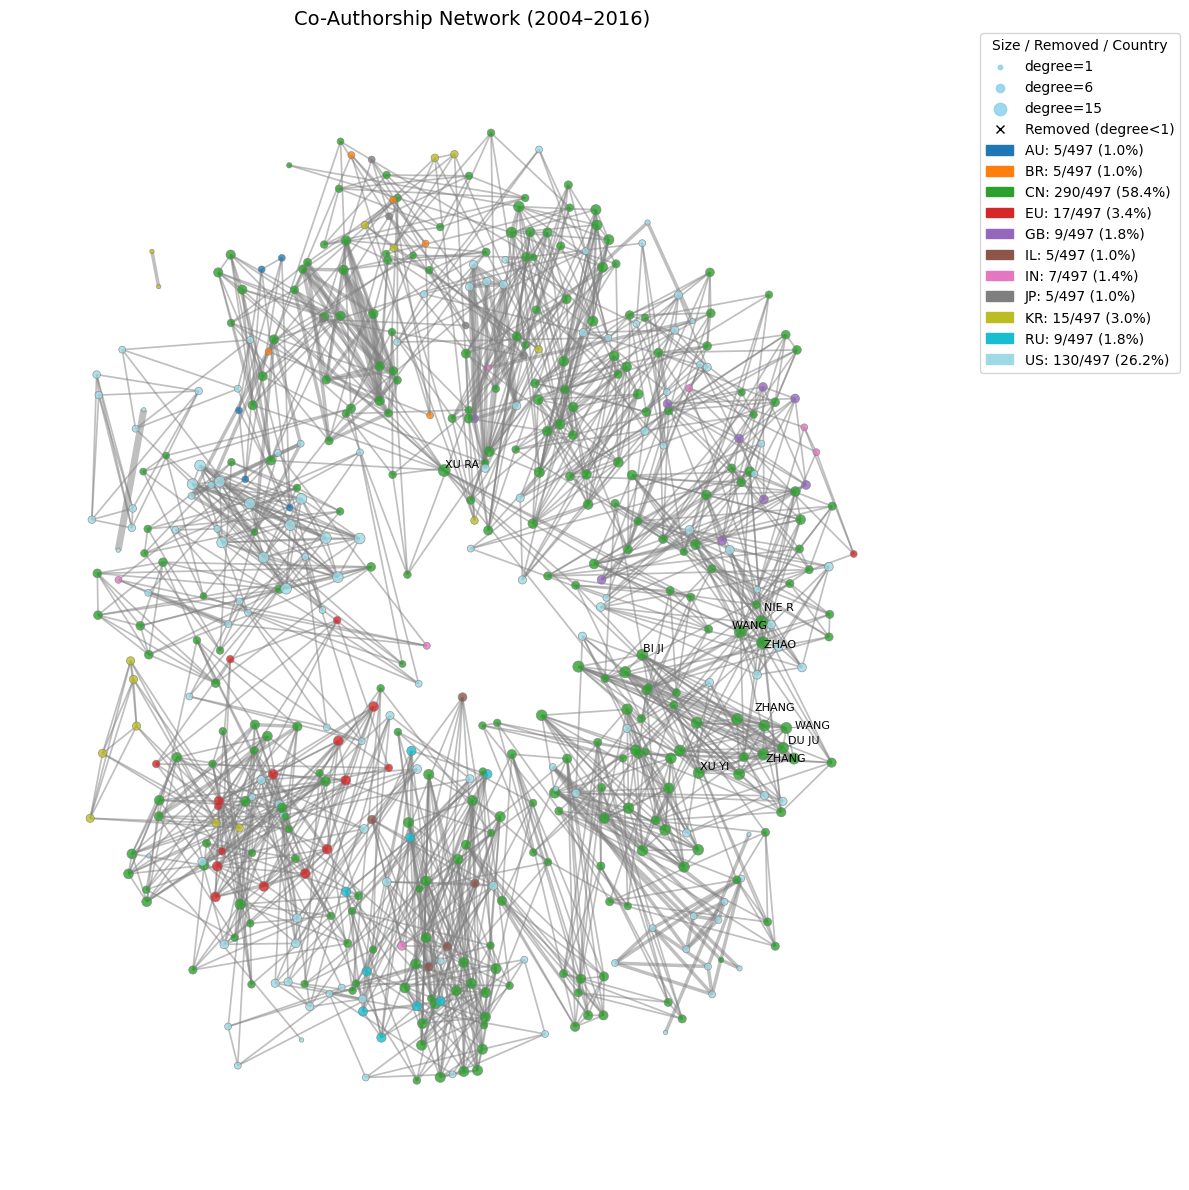

In [351]:
# 셀 8: Co-Authorship Network 시각화 — degree<1 제거, 국가별 색상, 이름 5자 제한, 레이블 겹침 방지, 범례에 비율/크기 반영, 약간 겹침 완화
import matplotlib.pyplot as plt                 # 시각화용 Matplotlib 불러오기
import networkx as nx                            # 그래프 조작용 NetworkX 불러오기
from adjustText import adjust_text               # 레이블 겹침 방지용 adjustText 불러오기
import matplotlib.patches as mpatches            # 범례용 컬러 패치 불러오기
import matplotlib.lines as mlines                # 범례용 선 모양 불러오기

min_degree = 1                                   # 제거 기준 degree 설정 (1 미만 제거)
nodes_kept = [n for n, d in G.degree() if d >= min_degree]  # degree ≥1인 노드만 선택
G2 = G.subgraph(nodes_kept).copy()               # 서브그래프 생성

pos = nx.spring_layout(G2, k=0.2, iterations=20, seed=42)   # 약간 더 벌어지도록 k 증가, 겹침 완화

deg = dict(G2.degree())                          # 노드별 degree dict 생성
nodes, degrees = zip(*deg.items())               # 노드 리스트와 degree 리스트로 분리
node_sizes = [(d + 1) * 5 for d in degrees]      # 노드 크기 설정 (d+1)*5 스케일

weights = [G2[u][v]['weight'] for u, v in G2.edges()]  # 엣지 weight 리스트 생성
widths = [w / max(weights) * 5 for w in weights] if weights else []  # 엣지 굵기 비율 계산

nat_map = {                                      # inventor 이름 → 국가 매핑
    n: df_expl2.loc[df_expl2['inventor'] == n, 'inventor_nat'].iloc[0]
    for n in nodes
}

EU_CODES = {                                     # EU 27개국 코드 집합 (영국 제외)
    "AT","BE","BG","HR","CY","CZ","DK","EE","FI","FR","DE","GR",
    "HU","IE","IT","LV","LT","LU","MT","NL","PL","PT","RO","SK","SI","ES","SE"
}
group_map = {                                    # 그룹핑: GB, EU, 기타
    n: (
        'GB' if nat_map.get(n) == 'GB' else
        'EU' if nat_map.get(n) in EU_CODES else
        nat_map.get(n, 'UN')
    )
    for n in nodes
}

unique_groups = sorted(set(group_map.values()))   # 고유 그룹 리스트 생성
cmap = plt.cm.get_cmap('tab20', len(unique_groups))  # 컬러맵 생성
color_map = {g: cmap(i) for i, g in enumerate(unique_groups)}  # 그룹→색 매핑
node_colors = [color_map[group_map[n]] for n in nodes]  # 노드별 색 리스트

plt.figure(figsize=(12, 12))                     # 그림 사이즈 설정
nx.draw_networkx_edges(G2, pos,
    width=widths, edge_color='gray', alpha=0.5   # 엣지 그리기
)
nx.draw_networkx_nodes(G2, pos,
    nodelist=nodes, node_size=node_sizes,        # 노드 그리기 (크기 적용)
    node_color=node_colors, alpha=0.8,            # 노드 그리기 (색상 적용)
    linewidths=0.5, edgecolors='grey'             # 노드 테두리 설정
)

top10 = sorted(deg, key=deg.get, reverse=True)[:10]  # 상위 10개 노드 선택
labels = {n: n[:5] for n in top10}               # 레이블 5자로 제한
texts = []
for n, lab in labels.items():
    x, y = pos[n]
    texts.append(plt.text(x, y, lab, fontsize=8))  # 레이블 추가
adjust_text(
    texts,
    expand_points=(1.1, 1.1),                     # 레이블 간격 약간만 확장
    arrowprops=dict(arrowstyle='-', color='gray', lw=0.5)  # 화살표 스타일
)

total_nodes = len(nodes)                         # 전체 노드 수
avg_deg = int(sum(degrees) / total_nodes)        # 평균 degree 계산
size_handles = [                                 # 노드 크기 범례 핸들 (스케일 일치)
    plt.scatter([], [], s=(d + 1) * 5, color='skyblue', alpha=0.8)
    for d in [min(degrees), avg_deg, max(degrees)]
]
size_labels = [f'degree={d}' for d in [min(degrees), avg_deg, max(degrees)]]  # 크기 레이블

removed_handle = mlines.Line2D(                  # 제거된 노드 정보 핸들
    [], [], linestyle='None', marker='x', color='black',
    label=f'Removed (degree<{min_degree})'
)

group_counts = {g: sum(1 for n in nodes if group_map[n] == g) for g in unique_groups}  # 그룹별 count
group_handles = [                               # 그룹별 색상 범례 핸들
    mpatches.Patch(
        color=color_map[g],
        label=f"{g}: {group_counts[g]}/{total_nodes} ({group_counts[g]/total_nodes:.1%})"
    )
    for g in unique_groups
]

all_handles = size_handles + [removed_handle] + group_handles  # 모든 핸들 합치기
all_labels = size_labels + [removed_handle.get_label()] + [h.get_label() for h in group_handles]
plt.legend(
    all_handles, all_labels,
    title='Size / Removed / Country',             # 범례 제목
    bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.0  # 범례 위치
)

plt.axis('off')                                   # 축 숨기기
plt.title(f'Co-Authorship Network ({min(year_sel)}–{max(year_sel)})', fontsize=14)  # 제목 설정
plt.tight_layout()                                # 레이아웃 조정
plt.show()                                        # 그래프 출력


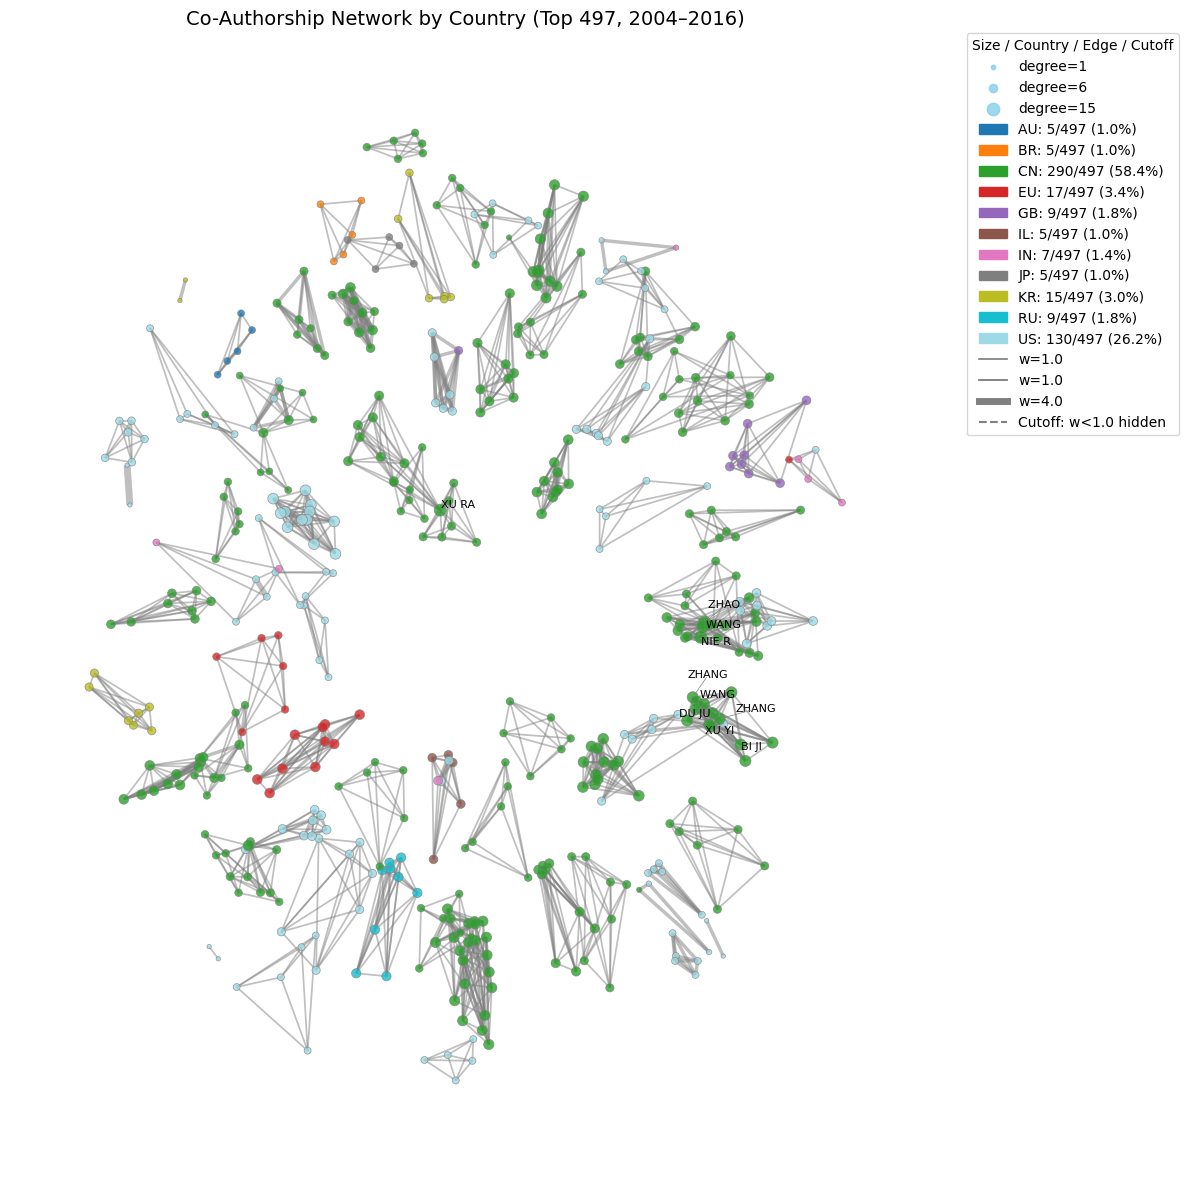

In [352]:
# 셀 9.1: 노드 색상 지정 (영국 제외한 EU는 하나의 그룹으로), 엣지 Cutoff=1.0, 레이블 겹침 방지, legend 및 제목 수정
import matplotlib.pyplot as plt             # 시각화용 Matplotlib
import networkx as nx                       # 그래프 조작용 NetworkX
import matplotlib.cm as cm                  # 컬러맵 모듈
import matplotlib.patches as mpatches       # 범례용 컬러 패치
import matplotlib.lines as mlines           # 범례용 선 모양
from adjustText import adjust_text          # 레이블 겹침 방지용

# 0) nodeㆍedge 준비
min_degree    = 1                                                      # degree 컷오프 기준
nodes_kept    = [n for n, d in G.degree() if d >= min_degree]          # degree ≥1 노드만
G2            = G.subgraph(nodes_kept).copy()                          # 서브그래프
deg           = dict(G2.degree()); nodes, degrees = zip(*deg.items())  # degree dict·리스트
node_sizes    = [(d + 1) * 5 for d in degrees]                         # 노드 크기 스케일

# 1) inventor → country mapping
nat_map = {
    n: df_expl2.loc[df_expl2['inventor']==n, 'inventor_nat'].iloc[0]
    for n in nodes
}

# 2) EU 그룹 정의 및 그룹핑
EU_CODES = {"AT","BE","BG","HR","CY","CZ","DK","EE","FI","FR","DE","GR",
            "HU","IE","IT","LV","LT","LU","MT","NL","PL","PT","RO","SK","SI","ES","SE"}
group_map = {
    n: ('EU' if nat_map[n] in EU_CODES else
        'GB' if nat_map[n]=='GB' else
        nat_map[n] or 'UN')
    for n in nodes
}

# 3) 그룹별 색상 매핑
unique_groups = sorted(set(group_map.values()))
cmap          = cm.get_cmap('tab20', len(unique_groups))
color_map     = {g: cmap(i) for i, g in enumerate(unique_groups)}
node_colors   = [color_map[group_map[n]] for n in nodes]

# 4) 엣지 필터링 (weight ≥1.0)
raw_edges      = list(G.edges(data='weight'))
raw_w          = [w for _,_,w in raw_edges]
threshold      = 1.0
filtered_edges = [(u,v) for u,v,w in raw_edges if w >= threshold]
widths         = [w/max(raw_w)*5 for _,_,w in raw_edges if w >= threshold]

# 5) 레이아웃 소폭 재배치
pos = nx.spring_layout(G, pos=pos, k=0.1, iterations=5, seed=42)

# 6) 그리기
plt.figure(figsize=(12,12))
nx.draw_networkx_edges(G, pos,
                       edgelist=filtered_edges, width=widths,
                       edge_color='gray', alpha=0.5)
nx.draw_networkx_nodes(G, pos,
                       nodelist=nodes, node_size=node_sizes,
                       node_color=node_colors, alpha=0.8,
                       linewidths=0.5, edgecolors='grey')

# 7) 레이블 (Top10, 5자 제한 + 겹침 방지)
top10 = sorted(deg, key=deg.get, reverse=True)[:10]
texts = [plt.text(*pos[n], n[:5], fontsize=8) for n in top10]
adjust_text(texts,
            expand_text=(1.5,1.5), expand_points=(2,2),
            force_text=(0.5,0.5), force_points=(0.2,0.2),
            arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))

# 8) 범례 준비
total_nodes  = len(nodes)  # 전체 노드 수
deg_min, deg_avg, deg_max = min(degrees), int(sum(degrees)/total_nodes), max(degrees)
# 8.1) node size legend
size_handles = [plt.scatter([],[], s=(d+1)*5, color='skyblue', alpha=0.8)
                for d in (deg_min, deg_avg, deg_max)]
size_labels  = [f'degree={d}' for d in (deg_min, deg_avg, deg_max)]
# 8.2) country legend
group_counts = {g: sum(1 for n in nodes if group_map[n]==g) for g in unique_groups}
group_handles = [mpatches.Patch(color=color_map[g],
                   label=f"{g}: {group_counts[g]}/{total_nodes} ({group_counts[g]/total_nodes:.1%})")
                 for g in unique_groups]
# 8.3) edge width legend
edge_stats   = [(min(raw_w), min(widths)), (threshold, sum(widths)/len(widths)), (max(raw_w), max(widths))]
edge_handles = [mlines.Line2D([],[], color='gray', lw=scaled, label=f"w={orig:.1f}")
                for orig, scaled in edge_stats]
# 8.4) cutoff legend
cut_handle   = mlines.Line2D([],[], linestyle='--', color='gray',
                             label=f'Cutoff: w<{threshold:.1f} hidden')
# combine and draw legend
all_handles = size_handles + group_handles + edge_handles + [cut_handle]
all_labels  = size_labels + [h.get_label() for h in group_handles] + \
              [h.get_label() for h in edge_handles] + [cut_handle.get_label()]
plt.legend(all_handles, all_labels,
           title='Size / Country / Edge / Cutoff',
           bbox_to_anchor=(1.05,1), loc='upper left', borderaxespad=0.)

# 9) 제목에 Top 노드 수 반영
plt.axis('off')
plt.title(f'Co-Authorship Network by Country (Top {total_nodes}, {min(year_sel)}–{max(year_sel)})', fontsize=14)  # 총 노드 수 포함

plt.tight_layout()
plt.show()


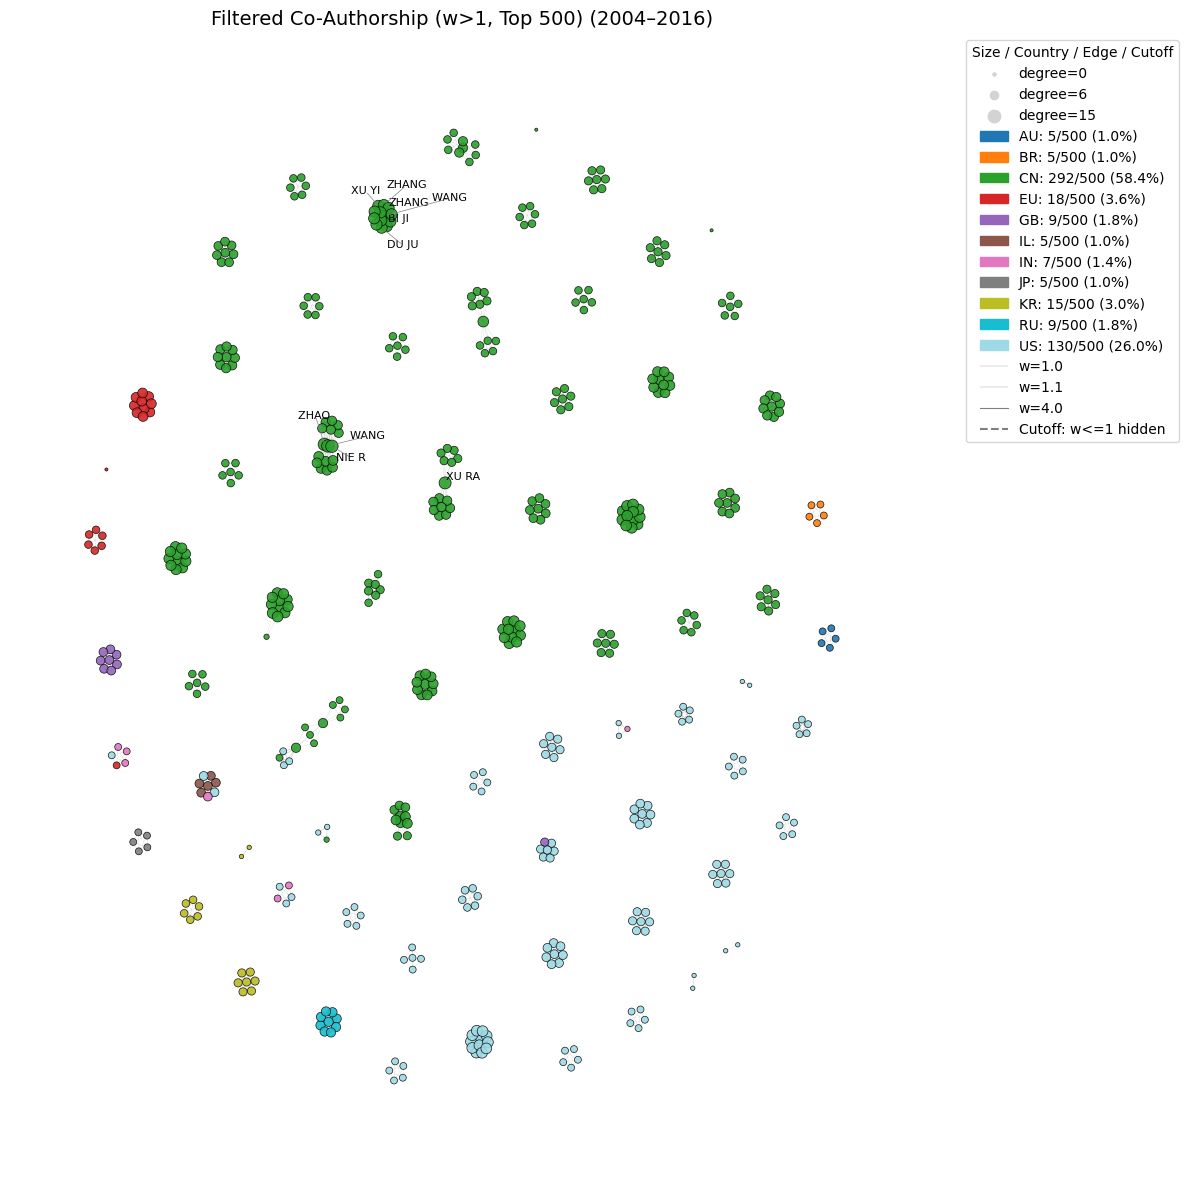

In [353]:
# 셀 9: 국가 기반 클러스터 레이아웃 + 노드 겹침 완화
import numpy as np                              # 수치 계산용 NumPy
import matplotlib.pyplot as plt                 # 시각화용 Matplotlib
import matplotlib.cm as cm                      # 컬러맵
import matplotlib.patches as mpatches           # 범례용 패치
import matplotlib.lines as mlines               # 범례용 선
import networkx as nx                           # 그래프 조작용 NetworkX
from adjustText import adjust_text              # 레이블 겹침 방지용 adjustText

# 0) 엣지 컷오프: weight <1 제거
edges_to_remove = [(u, v) for u, v, d in G.edges(data=True) if d['weight'] < 1]  # 컷오프된 엣지 목록
G_filtered     = G.copy()    # 원본 그래프 복사
G_filtered.remove_edges_from(edges_to_remove)  # 컷오프 적용

# 1) top1000 노드 서브그래프
deg_f   = dict(G_filtered.degree())   # degree dict 생성
top_nodes_f = sorted(deg_f, key=deg_f.get, reverse=True)[:1000]                 # 상위 1000 노드
G_sub  = G_filtered.subgraph(top_nodes_f).copy()   # 서브그래프

# 2) 노드→국가 코드 매핑 및 EU 통합
tat = {n: df_expl2.loc[df_expl2['inventor']==n, 'inventor_nat'].iloc[0] for n in G_sub.nodes()}  # 노드→국가
EU_CODES = {"AT","BE","BG","HR","CY","CZ","DK","EE","FI","FR","DE","GR","HU","IE","IT","LV","LT","LU","MT","NL","PL","PT","RO","SK","SI","ES","SE"}
group_map = {n: ('EU' if tat[n] in EU_CODES else tat[n] or 'UN') for n in G_sub.nodes()}  # EU 통합

# 3) 그룹별 중심 원 위에 균등 분포
groups  = sorted(set(group_map.values()))    # 그룹 목록
angles  = np.linspace(0, 2*np.pi, len(groups), endpoint=False)  # 균등한 각도
centers = {g: np.array([np.cos(a), np.sin(a)]) for g, a in zip(groups, angles)}   # 그룹 중심 좌표

# 4) 초기 위치: 그룹 중심 + 랜덤 오프셋
pos_init = {n: centers[group_map[n]] + 0.1 * np.random.randn(2) for n in G_sub.nodes()}  # 초기 pos 설정



# 5) 스프링 레이아웃 적용 (k=3.0, iterations=200으로 노드 간격 넉넉히)
pos = nx.spring_layout(G_sub, pos=pos_init, k=3.0, iterations=200, seed=42)     # repulsion 크게
scale = 1.5                                                                    # 좌표 스케일링 비율
pos = {n: coord * scale for n, coord in pos.items()}


# 6) 스타일 계산
deg_sub     = dict(G_sub.degree())   # degree dict
nodes_sub, degrees_sub = zip(*deg_sub.items())  # 노드, degree 리스트
node_sizes  = [(d + 1) * 5 for d in degrees_sub]   # 노드 크기
weights_sub = [d['weight'] for _,_,d in G_sub.edges(data=True)] # 엣지 weight 리스트
widths_sub  = [max(w * 0.2, 0.1) for w in weights_sub]    # 엣지 굵기

# 7) 색상 매핑
unique_groups = sorted(set(group_map.values()))    # 고유 그룹
cmap          = cm.get_cmap('tab20', len(unique_groups))  # 컬러맵
color_map     = {g: cmap(i) for i, g in enumerate(unique_groups)}   # 그룹→색
node_colors   = [color_map[group_map[n]] for n in G_sub.nodes()]  # 노드별 색

# 8) 시각화: 엣지 → 노드
plt.figure(figsize=(12,12))                                                      # 그림 크기
nx.draw_networkx_edges(G_sub, pos, width=widths_sub, edge_color='gray', alpha=0.4)  # 엣지 그리기
nx.draw_networkx_nodes(G_sub, pos, node_size=node_sizes, node_color=node_colors, alpha=0.9, linewidths=0.5, edgecolors='black')  # 노드 그리기

# 9) 라벨링: 상위 10개 노드 5자 + 겹침 방지
top10_sub = sorted(deg_sub, key=deg_sub.get, reverse=True)[:10]  # 상위 10개
texts = [plt.text(*pos[n], n[:5], fontsize=8) for n in top10_sub]  # 5자 라벨
adjust_text(texts, expand_text=(1.5,1.5), expand_points=(2,2), force_text=(0.5,0.5), force_points=(0.2,0.2), arrowprops=dict(arrowstyle='-', color='gray', lw=0.5), lim=1000)  # 레이블 겹침 방지

# 10) 범례 준비
total_nodes  = len(nodes_sub)     # 전체 노드 수
degree_vals  = [min(degrees_sub), int(sum(degrees_sub)/total_nodes), max(degrees_sub)]  # degree 값
size_handles = [plt.scatter([], [], s=(d+1)*5, color='lightgray', label=f'degree={d}') for d in degree_vals]  # 노드 크기 범례
group_counts = {g: sum(1 for n in nodes_sub if group_map[n]==g) for g in unique_groups}  # 그룹별 count
color_handles = [mpatches.Patch(color=color_map[g], label=f"{g}: {group_counts[g]}/{total_nodes} ({group_counts[g]/total_nodes:.1%})") for g in unique_groups]  # 국가 범례
link_vals    = [min(weights_sub), sum(weights_sub)/len(weights_sub), max(weights_sub)]  # weight 값
link_handles = [mlines.Line2D([], [], color='gray', linewidth=max(w*0.2,0.1), label=f"w={w:.1f}") for w in link_vals]  # 엣지 굵기 범례
cut_handle   = mlines.Line2D([], [], linestyle='--', color='gray', label='Cutoff: w<=1 hidden')  # 컷오프 범례
plt.legend(handles=size_handles + color_handles + link_handles + [cut_handle], title='Size / Country / Edge / Cutoff', bbox_to_anchor=(1.05,1), loc='upper left')  # 범례

# 11) 마무리 스타일링
plt.axis('off')   # 축 숨김
plt.title(f'Filtered Co-Authorship (w>1, Top {total_nodes}) ({min(year_sel)}–{max(year_sel)})', fontsize=14)  # 제목
plt.tight_layout()    # 레이아웃 자동 조정
plt.show()      # 그래프 출력


In [354]:
# 셀 10: 연도·PTO_type별 특허 건수 집계, Total 행 추가 및 CSV 저장 (깔끔한 표 출력)
import pandas as pd    # 데이터 처리용 pandas
import os              # 파일 경로 조작용

# 1) 중복 제거
df_type = (
    df_expl2[['year','PTO_type','appl_id']]
      .drop_duplicates()               # (year, PTO_type, appl_id) 중복 제거
)

# 2) 집계
patent_counts_by_type = (
    df_type
      .groupby(['year','PTO_type'])    # 연도·PTO_type별 그룹화
      .size()                          # 특허 건수 카운트
      .reset_index(name='patent_count')
      .pivot(index='year', columns='PTO_type', values='patent_count')
      .fillna(0).astype(int)          # NaN→0, 정수형 변환
)

# 3) Total 행 추가
total_row = patent_counts_by_type.sum(axis=0)  # 열별 합계 계산
total_row.name = 'Total'                       # 행 이름 지정
patent_counts_by_type = pd.concat([
    patent_counts_by_type,
    pd.DataFrame([total_row])
])

# 4) CSV 저장
out_path = os.path.join(base_dir, 'patent_by_PTO_type.csv')
patent_counts_by_type.to_csv(out_path, index=True)  # index(연도+Total) 포함


In [355]:
patent_counts_by_type

PTO_type    CN  EP  KR   US
2003         0   0   0    1
2004         0   0   0    3
2005         0   0   0    4
2006         0   0   0    2
2007         2   0   0    5
2008         3   0   0    3
2009         4   0   0   12
2010         8   0   0    8
2011         9   0   1   20
2012        19   0   0   18
2013        27   0   2   24
2014        37   4   3   32
2015        53   3   2   32
2016        71   2   2   38
2017       110   1   0   47
2018       158   2   0   51
2019       264   2   2   70
2020       208   0   8   66
2021       187   2   5   34
2022       107   0   3    8
2023        67   0   5    0
Total     1334  16  33  478

In [356]:
# 셀 11: 연도·출원 국가별 집계 (EU 그룹 포함) 및 Total 행 추가
import numpy as np      # 수치 연산용 NumPy
import pandas as pd     # 데이터 처리용 pandas
import os               # 파일 경로 조작용

# 1) country_code & country_group 생성
df_country = df_expl2.copy()

# applicant_nat을 문자열로 변환한 뒤, 앞 2글자 추출 및 대문자화
df_country['country_code'] = (
    df_country['applicant_nat']
      .fillna('')              # NaN → 빈 문자열
      .astype(str)             # 문자열로 변환
      .str[:2]                 # 앞 2글자 추출
      .str.upper()             # 대문자화
)

EU_CODES = {
    "AT","BE","BG","HR","CY","CZ","DK","EE","FI","FR","DE","GR",
    "HU","IE","IT","LV","LT","LU","MT","NL","PL","PT","RO","SK","SI","ES","SE"
}
df_country['country_group'] = np.where(
    df_country['country_code'].isin(EU_CODES),
    'EU',
    df_country['country_code']
)

# 2) 중복 제거: (year, country_group, appl_id)
df_country = (
    df_country[['year', 'country_group', 'appl_id']]
      .drop_duplicates()
)

# 3) 연도·그룹별 특허 건수 집계 및 pivot
patent_counts_by_country = (
    df_country
      .groupby(['year', 'country_group'])
      .size()
      .reset_index(name='patent_count')
      .pivot(index='year', columns='country_group', values='patent_count')
      .fillna(0)
      .astype(int)
)

# 4) Total 행 추가
total_row = patent_counts_by_country.sum(axis=0)
total_row.name = 'Total'
patent_counts_by_country = pd.concat([
    patent_counts_by_country,
    pd.DataFrame([total_row], index=['Total'])
])


# 5) CSV로 저장
out_path2 = os.path.join(base_dir, 'patent_counts_by_country_by_year.csv')
patent_counts_by_country.to_csv(out_path2, index=True)


In [357]:
patent_counts_by_country

country_group  CA  CH    CN  EU  GB  HK  IL  IN  JP  KR  KY  RU  SA  SG  TW  \
2003            0   0     0   0   0   0   0   0   0   0   0   0   0   0   0   
2004            0   0     0   0   0   0   0   0   0   0   0   0   0   0   1   
2005            0   0     0   0   0   0   1   0   1   0   0   0   0   0   0   
2006            0   0     0   0   0   0   0   0   0   0   0   0   0   0   0   
2007            0   0     2   0   0   0   0   0   0   0   0   0   0   0   0   
2008            0   0     2   0   0   0   0   0   0   0   0   0   0   0   0   
2009            1   0     2   3   0   0   1   1   0   0   1   0   0   0   0   
2010            2   0     6   0   0   0   0   0   0   0   0   0   0   0   0   
2011            1   0     7   3   0   0   0   1   0   1   0   0   0   0   0   
2012            0   0    15   3   1   0   0   1   0   0   0   0   0   0   0   
2013            1   1    27   2   0   0   0   1   0   3   0   0   0   0   1   
2014            0   1    30   3   0   0   4   2   0   3   3   1   0   0   0   
2015            0   1    54   5   0   0   0   0   3   3   0   0   0   0   0   
2016            1   0    71   6   0   0   0   1   0   2   1   0   0   0   1   
2017            0   1   111   6   0   0   0   1   4   0   0   0   0   0   1   
2018            3   0   161   2   0   0   1   1   3   2   2   0   0   0   1   
2019            2   0   269   5   1   0   0   0   2   4   2   0   1   0   0   
2020            2   0   217   2   1   0   2   1   1   8   0   0   0   0   1   
2021            2   0   190   5   0   2   3   2   0   6   0   0   1   1   1   
2022            1   0   110   0   0   0   1   0   0   3   0   0   0   0   0   
2023            0   0    67   0   0   0   0   0   0   5   0   0   0   0   0   
Total          16   4  1341  45   3   2  13  12  14  40   9   1   2   1   7   

country_group   US  
2003             1  
2004             2  
2005             2  
2006             2  
2007             5  
2008             4  
2009             7  
2010             8  
2011            17  
2012            17  
2013            17  
2014            29  
2015            24  
2016            30  
2017            34  
2018            35  
2019            52  
2020            47  
2021            15  
2022             3  
2023             0  
Total          351

In [358]:
# df_expl2 중간 확인
display(
    df_expl2[
        ['appl_id','year', 'PTO_type', 'applicant', 'applicant_main_code',  'applicant_nat','country_code','inventor','num_inventors','inventor_nat', 'title', 'abstract', 'claim_main']
    ]
    # .sort_values(by='applicant', ascending=False)
    .head(1)
)


appl_id  year PTO_type             applicant applicant_main_code  \
0  16/283492  2019       US  HALOGEN NETWORKS LLC                 NaN   

  applicant_nat country_code          inventor  num_inventors inventor_nat  \
0            US           US  NICHOLAS PONTIFF             12           US   

                                               title  \
0  Interactive sentiment-detecting video streamin...   

                                            abstract  \
0  Embodiments of the systems, methods, and compu...   

                                          claim_main  
0  1. A video streaming system comprising: one or...

In [359]:
# 1) appl_id 기준으로 중복 제거, 첫 번째 행 유지
df_expl2 = df_expl2.drop_duplicates(subset=['appl_id'], keep='first')

# 2) 중간 확인
display(
    df_expl2[
        ['appl_id','year','PTO_type','applicant','applicant_main_code',
         'applicant_nat','country_code','inventor','num_inventors',
         'inventor_nat','title','abstract','claim_main']
    ]
    # .sort_values(by='applicant', ascending=False)
    .head(1)
)


appl_id  year PTO_type             applicant applicant_main_code  \
0  16/283492  2019       US  HALOGEN NETWORKS LLC                 NaN   

  applicant_nat country_code          inventor  num_inventors inventor_nat  \
0            US           US  NICHOLAS PONTIFF             12           US   

                                               title  \
0  Interactive sentiment-detecting video streamin...   

                                            abstract  \
0  Embodiments of the systems, methods, and compu...   

                                          claim_main  
0  1. A video streaming system comprising: one or...

In [360]:
df_expl2.shape

(1861, 50)

In [361]:
df_expl2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1861 entries, 0 to 1860
Data columns (total 50 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   PTO_id                 1861 non-null   object        
 1   PTO_type               1861 non-null   object        
 2   patent_kind            1861 non-null   object        
 3   pub_type_code          1861 non-null   object        
 4   title                  1861 non-null   object        
 5   title_en               1828 non-null   object        
 6   abstract               1861 non-null   object        
 7   abstract_en            1828 non-null   object        
 8   claim_main             1861 non-null   object        
 9   claim_main_en          1828 non-null   object        
 10  claims_indep           1861 non-null   object        
 11  claims_indep_en        1828 non-null   object        
 12  num_claims             1861 non-null   int64         
 13  appl_id 

In [362]:
# ==============================================
# PatentSBERTa 기반 특허 텍스트 분류/검색 파이프라인 (경량/고속)
# 목적: 기존 BERT 전체 미세튜닝 대신, ① 임베딩 + 경량 분류기 또는 ② 선택적 LoRA 미세튜닝으로 시간 단축
# ==============================================
# 구성
# 셀 1: 환경 설정 및 패키지 설치
# 셀 2: 라이브러리 로드 및 기본 설정
# 셀 3: 데이터 로딩 (예시: CSV) + 전처리
# 셀 4: Train/Validation 분할
# 셀 5: PatentSBERTa 임베딩 모델 로드
# 셀 6: 임베딩 생성 (캐시 지원)
# 셀 7: 경량 분류기(LogisticRegression) 학습
# 셀 8: 평가 (분류 리포트, 혼동행렬)
# 셀 9: 저장 (임베딩 모델, 분류기, 라벨 인코더)
# 셀 10: 로드 및 추론 함수
# 셀 11: 대량 파일/스트리밍 처리 유틸
# 셀 12 (옵션): LoRA 미세튜닝 (필요 시만 실행)
# 셀 13 (옵션): LoRA 모델 평가 및 저장
# ==============================================


In [363]:
# 셀 12-(1): 환경 초기화 및 호환 버전 설치

# 0) 충돌 제거
!pip uninstall -y torch torchvision torchaudio fastai pillow 2>/dev/null || true

# 1) 필수 라이브러리 (torch 2.6.0 + cu124 / torchvision 0.21.0 + cu124)
!pip install -U pip
!pip install --index-url https://download.pytorch.org/whl/cu124 \
    torch==2.6.0+cu124 torchvision==0.21.0+cu124 torchaudio==2.6.0

# 2) 나머지 패키지
!pip install -q sentence-transformers>=2.7.0 scikit-learn pandas numpy fastai==2.7.19

# 3) (선택) vision 비활성화 플래그 – transformers 가 vision 서브모듈 로딩 방지
import os
os.environ["TRANSFORMERS_NO_TORCHVISION"] = "1"
os.environ["DISABLE_TRANSFORMERS_AV"] = "1"

# 4) 설치 확인
import torch
import torchvision
import PIL

print("Torch        :", torch.__version__)
print("Torchvision  :", torchvision.__version__)
print("Pillow       :", PIL.__version__)
try:
    import fastai
    print("FastAI       :", fastai.__version__)
except:
    print("FastAI not installed")


Found existing installation: torch 2.6.0+cu124
Uninstalling torch-2.6.0+cu124:
  Successfully uninstalled torch-2.6.0+cu124
Found existing installation: torchvision 0.21.0+cu124
Uninstalling torchvision-0.21.0+cu124:
  Successfully uninstalled torchvision-0.21.0+cu124
Found existing installation: torchaudio 2.6.0+cu124
Uninstalling torchaudio-2.6.0+cu124:
  Successfully uninstalled torchaudio-2.6.0+cu124
Found existing installation: fastai 2.7.19
Uninstalling fastai-2.7.19:
  Successfully uninstalled fastai-2.7.19
Found existing installation: pillow 11.0.0
Uninstalling pillow-11.0.0:
  Successfully uninstalled pillow-11.0.0
Looking in indexes: https://download.pytorch.org/whl/cu124
  Using cached https://download.pytorch.org/whl/cu124/torch-2.6.0%2Bcu124-cp311-cp311-linux_x86_64.whl.metadata (28 kB)
  Using cached https://download.pytorch.org/whl/cu124/torchvision-0.21.0%2Bcu124-cp311-cp311-linux_x86_64.whl.metadata (6.1 kB)
  Using cached https://download.pytorch.org/whl/cu124/torchau

In [364]:
# 셀 12-(2): 기본 import 및 전역 설정
import os, re                                                        # OS, 정규식
import numpy as np                                                   # 수치 연산
import pandas as pd                                                  # 데이터프레임
from sklearn.model_selection import train_test_split                 # 데이터 분할
TEXT_COLS = ["title","abstract","claim_main"]                        # 결합할 텍스트 컬럼 지정
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"              # GPU/A100 사용 여부
print("Device:", DEVICE)                                             # 디바이스 출력


Device: cuda


In [365]:
# df_expl2를 복사하여 df_expl3 생성
# 원본 보존용 복제본 생성
df_expl3 = df_expl2.copy()


In [366]:
df_expl3.shape

(1861, 50)

In [367]:
df_expl3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1861 entries, 0 to 1860
Data columns (total 50 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   PTO_id                 1861 non-null   object        
 1   PTO_type               1861 non-null   object        
 2   patent_kind            1861 non-null   object        
 3   pub_type_code          1861 non-null   object        
 4   title                  1861 non-null   object        
 5   title_en               1828 non-null   object        
 6   abstract               1861 non-null   object        
 7   abstract_en            1828 non-null   object        
 8   claim_main             1861 non-null   object        
 9   claim_main_en          1828 non-null   object        
 10  claims_indep           1861 non-null   object        
 11  claims_indep_en        1828 non-null   object        
 12  num_claims             1861 non-null   int64         
 13  appl_id 

In [368]:
# 방법 1: 전체 중복된 행 수 (첫 번째 이후 중복 건수)
dup_count = df_expl3['appl_id'].duplicated().sum()
print(f"중복된 appl_id 행 수: {dup_count}")

# 방법 2: 각 appl_id별 빈도 집계 후, 2회 이상 등장한 모든 건수 합산
vc = df_expl3['appl_id'].value_counts()           # appl_id별 출현 횟수 계산
dup_total = vc[vc > 1].sum()                      # 2회 이상인 횟수들만 합산
print(f"중복된 appl_id 총 출현 수: {dup_total}")

# 방법 3: 유니크한 중복 appl_id 개수
unique_dup_ids = (vc > 1).sum()                   # 2회 이상 등장하는 appl_id 개수
print(f"중복된 고유 appl_id 개수: {unique_dup_ids}")


중복된 appl_id 행 수: 0
중복된 appl_id 총 출현 수: 0
중복된 고유 appl_id 개수: 0


In [369]:
# ==============================================
# 셀 12-(3): fulltext 생성 및 Seed LLM 라벨 생성 (확장 + 한국어 상세 주석 강화)
# ==============================================
# 목적:
#  - 특허/문헌 텍스트에서 LLM/Transformer 관련 기술·모델·방법론 언급 여부를 1/0 라벨로 부여
#  - 다국어(한/중/일) 및 최신 한국/중국/글로벌 모델명 포함
#  - 구조적(카테고리별) 키워드 관리 → 유지보수 용이
#  - False Positive(일반 단어와 충돌) 최소화를 위한 후처리 옵션 제공

# 전제:
#  - TEXT_COLS: 결합할 텍스트 컬럼 리스트 (이미 상위 셀에서 정의되어 있다고 가정)
#  - df_expl3: 라벨을 부여할 DataFrame
#  - fulltext 컬럼이 없으면 생성, 있으면 재사용

def combine_text(r):
    """
    행(row)의 TEXT_COLS 내 텍스트를 결합하여 fulltext 문자열 생성.
    - None/빈 문자열/비문자 타입(예: float, int)은 제외
    - 줄바꿈 전/후 공백 제거
    - 구분은 " \n " (줄 단위로 결합) → 추후 문장 분해/패턴 매칭 시 가독성 유지
    """
    return " \n ".join([
        str(r[c]).strip()
        for c in TEXT_COLS
        if c in r and isinstance(r[c], str) and r[c].strip()
    ])

# fulltext 컬럼이 없을 경우에만 생성 (이미 전처리에서 만든 경우 중복 연산 회피)
if "fulltext" not in df_expl3.columns:
    df_expl3["fulltext"] = df_expl3.apply(combine_text, axis=1)

import re

# ==============================================
# (A) 카테고리별 키워드 정의
#  - 각 리스트는 해당 주제/범주에 속하는 정규식 패턴 문자열
#  - 패턴 작성 원칙:
#     * 소문자/대문자 구분 제거: re.IGNORECASE 사용
#     * 변형/숫자/Parameter size(7B, 13B 등)는 (?:[-\s]?[0-9]+[bBkK]?)? 로 포괄
#     * 하이픈/공백 모두 허용: [-\s]? 또는 [-\s]?복합 사용
#     * 과매칭 위험(일반 단어) → 후처리(filter_false_positives)에서 문맥 검사
#  - 필요 시 특정 카테고리를 제외하면 즉시 정규식 범위 축소 가능
# ==============================================

# -------- core_models : 모델명(브랜드/패밀리) --------
# --------------------------------------------------------
# core_models : 전세계 + 중국 + 한국 LLM 고유명사/브랜드/대표 패밀리
# - 목적: 텍스트 안에 특정 모델 언급(특허/논문/기사) 탐지
# - 포함: 상용(Claude, Gemini), 오픈소스(LLaMA, Mistral), 연구(BLOOM, Chinchilla), 중국(Qwen, DeepSeek, KIMI, ChatGLM 등), 한국(HyperCLOVA, EXAONE, SOLAR, Midm 등)
# - 주의: 일반 단어와 충돌 가능 (claude, ernie, solar 등) → 후처리 필터 권장
# --------------------------------------------------------
# 주의: 'claude', 'ernie', 'solar' 는 일반 단어/인명과 충돌 가능
core_models = [
    # 글로벌 / 오픈 / 상용
    r'large language model', r'LLM', r'neural language model(?:s)?',
    r'foundation model', r'chatgpt', r'gpt[-\s]?[0-9]+(?:\.[0-9])?',
    r'bert(?:-\w+)?', r'roberta', r't5', r'longt5', r'xlnet', r'albert', r'distilbert',
    r'ul2', r'falcon', r'mistral', r'mixtral', r'gemma', r'orca',
    r'phi[-\s]?[0-9]+', r'openelm', r'vicuna', r'guanaco',
    # LLaMA 계열
    r'llama(?:[-\s]?(?:[0-9]+[bBkK]?|2|3))?', r'codellama', r'openllama',
    # 주요 상용/대형
    r'claude(?:[-\s]?[0-9]+)?',          # FP 가능 (인명) → 후처리
    r'gemini(?:[-\s]?(?:pro|ultra|flash)?)?',
    r'palm[-\s]?2', r'palm2',
    r'opt(?:[-\s]?[0-9]+[bBkK]?)?', r'gopher', r'chinchilla',
    r'megatron[-\s]?turing(?:[-\s]?nlg)?', r'mt[-\s]?nlg', r'megatron',
    r'gpt[-\s]?neox(?:[-\s]?[0-9]+[bBkK]?)?', r'gpt[-\s]?neo(?:[-\s]?[0-9]+[bBkK]?)?',
    r'gpt[-\s]?j(?:[-\s]?[0-9]+[bBkK]?)?',
    # 커뮤니티 / 오픈
    r'bloomz?(?:[-\s]?[0-9]+[bBkK]?)?', r'jurassic(?:[-\s]?(?:1|2|jr))?',
    r'mpt(?:[-\s]?[0-9]+[bBkK]?)?', r'pythia(?:[-\s]?[0-9]+[bBkK]?)?',
    r'dolly(?:[-\s]?[0-9]+[bBkK]?)?', r'stablelm(?:[-\s]?[0-9]+[bBkK]?)?',
    r'rwkv(?:[-\s]?[0-9]+[bBkK]?)?', r'starcoder(?:[-\s]?[0-9]+[bBkK]?)?',
    r'codegen(?:[-\s]?[0-9]+[bBkK]?)?', r'codet5(?:[-\s]?[0-9]+[bBkK]?)?',
    r'wizardlm(?:[-\s]?[0-9]+[bBkK]?)?', r'wizardcoder(?:[-\s]?[0-9]+[bBkK]?)?',
    r'zephyr(?:[-\s]?[0-9]+[bBkK]?)?', r'phi(?:[-\s]?[0-9]+[bBkK]?)?',
    r'medalpaca', r'finet5', r'biogpt', r'chemberta',
    r'CodeBERT', r'BioBERT', r'clinicalbert',
    # 중국
    r'ernie', r'wenxin', r'ernie bot', r'qwen(?:[-\s]?[0-9]+[bBkK]?)?',
    r'deepseek(?:[-\s]?[0-9]+[bBkK]?)?', r'yi(?:[-\s]?[0-9]+[bBkK]?)?',
    r'baichuan(?:[-\s]?[0-9]+[bBkK]?)?', r'chatglm(?:[-\s]?[0-9]+)?',
    r'internlm(?:[-\s]?[0-9]+[bBkK]?)?', r'pangu(?:[-\s]?[0-9]+[bBkK]?)?',
    r'sparkdesk', r'sensechat', r'kimi(?:[-\s]?chat)?', r'abab(?:[-\s]?[\w]+)?',
    r'ziya', r'm6', r'aquila(?:[-\s]?[\w]+)?',
    # 한국
    r'hyperc[lL]ova(?:[-\s]?(?:x|2|[0-9]+[bBkK]?))?', r'kogpt(?:[-\s]?[0-9]+[bBkK]?)?',
    r'polyglot(?:[-\s]?ko)?(?:[-\s]?[0-9]+[bBkK]?)?', r'koalpaca',
    r'clovax', r'클로바엑스', r'solar(?:[-\s]?[0-9]+[bBkK]?)?', r'솔라',
    r'exaone(?:[-\s]?(?:2|2\.0|[0-9]+[bBkK]?))?', r'엑사원',
    r'kullm(?:[-\s]?[0-9]+[bBkK]?)?', r'kovicuna', r'코비쿠나',
    r'kolama', r'kollama', r'korwkv', r'kollm', r'kocoder',
    r'korean[-\s]?stablelm', r'korealm', r'하이퍼클로바', r'한국어\s?LLM'
]

# -------- 아키텍처 변형 / 구조적 확장 --------
# model_variants_arch : 아키텍처 확장/변형 (희소, 확장, 특수구조)
# - 목적: 구조적 혁신(Perceiver, Mixture-of-Experts, State Space 등) 탐지
# - FP 낮음 (대부분 전문 용어)
# --------------------------------------------------------
model_variants_arch = [
    r'transformer[-\s]?(?:based|encoder|decoder)?', r'encoder[-\s]?decoder',
    r'sequence-to-sequence', r'esm(?:[-\s]?[0-9]+)?',
    r'mixture[-\s]?of[-\s]?experts', r'MoE', r'sparsely[-\s]?gated mixture[-\s]?of[-\s]?experts',
    r'Switch[-\s]?Transformer', r'GShard', r'stacked mixture[-\s]?of[-\s]?experts',
    r'sparse transformer', r'perceiver(?:[-\s]?IO)?', r'transformer[-\s]?xl',
    r'hierarchical transformer', r'dynamic convolution', r'conformer',
    r'hypernetwork', r'graph transformer', r'state space model', r'Mamba'
]

# -------- 어텐션 / 포지셔널 / 컨텍스트 --------
# attention_positional : 어텐션 및 위치/컨텍스트 처리 기법
# - 목적: 효율/성능/긴문맥 관련 메커니즘 추출
# - 활용: 모델 성능·추론최적화 연구 태깅
# --------------------------------------------------------
attention_positional = [
    r'self[-\s]?attention', r'multi[-\s]?head attention', r'attention mechanism',
    r'sparse attention', r'global attention', r'local attention', r'axial attention',
    r'linear attention', r'flash attention', r'scaled dot[-\s]?product attention',
    r'cross[-\s]?attention', r'memory attention', r'rotary positional embedding', r'RoPE',
    r'ALiBi', r'relative positional encoding', r'absolute positional encoding',
    r'sinusoidal positional encoding', r'position[-\s]?wise feed[-\s]?forward',
    r'kv[-\s]?cache', r'windowed attention', r'blockwise attention'
]

# -------- 파라미터 효율 / PEFT --------
# parameter_efficiency : 파라미터 효율 미세조정(PEFT) 기법
# - 목적: 비용 절감·경량화 기법 탐지
# - 분석 포인트: 모델 재사용성, 적은 데이터 적응
# --------------------------------------------------------
parameter_efficiency = [
    r'parameter[-\s]?efficient fine[-\s]?tuning', r'PEFT', r'LoRA', r'QLoRA',
    r'adapter(?:s)?', r'adapter[-\s]?layer', r'prefix[-\s]?tuning', r'prompt[-\s]?tuning',
    r'soft prompt(?:ing)?', r'p[-\s]?tuning', r'bitfit', r'low[-\s]?rank adaptation',
    r'sparse fine[-\s]?tuning', r'lightweight fine[-\s]?tuning', r'hypernetwork adaptation',
    r'lora[-\s]?merged', r'training head', r'partial fine[-\s]?tuning'
]

# -------- 학습 패러다임 / 정렬 / 목적 --------
# training_paradigms : 학습 목적·전략·튜닝 프로세스
# - 목적: 사전학습 목적 / 튜닝 종류 / 정렬 학습 방식 태깅
# - DPO, RLAIF 등 최신 preference 최적화 포함
# --------------------------------------------------------
training_paradigms = [
    r'pretraining', r'pre[-\s]?training', r'masked language model(?:s)?',
    r'autoregressive model(?:s)?', r'denoising objective', r'causal language modeling',
    r'span corruption', r'instruction[-\s]?tuning', r'supervised fine[-\s]?tuning',
    r'SFT', r'alignment tuning', r'contrastive learning', r'multi[-\s]?task learning',
    r'domain adaptation', r'curriculum learning', r'continual learning',
    r'reinforcement learning from human feedback', r'RLHF',
    r'RLAIF', r'DPO', r'direct preference optimization',
    r'offline reinforcement learning', r'self[-\s]?distillation', r'knowledge distillation'
]

# -------- 프롬프트 / 추론 / Reasoning --------
# prompting_inference : 프롬프트 설계·추론 강화·Reasoning 전략
# - 목적: CoT, ReAct, Tree-of-Thought 등 추론 향상 패턴 탐지
# - 활용: reasoning 성능 비교, 기법 빈도 분석
# --------------------------------------------------------
prompting_inference = [
    r'prompt[-\s]?engineering', r'prompt[-\s]?tuning', r'prompt design',
    r'few[-\s]?shot (?:learning|inference)', r'one[-\s]?shot learning', r'zero[-\s]?shot learning',
    r'chain[-\s]?of[-\s]?thought', r'CoT', r'self[-\s]?consistency',
    r'tree[-\s]?of[-\s]?thought', r'graph[-\s]?of[-\s]?thought', r'deliberate reasoning',
    r'scratchpad', r'react framework', r'REACT', r'function calling', r'tool use',
    r'planning prompting', r'reflection prompting', r'progressive hinting',
    r'role prompting', r'instruction following', r'reasoning step'
]

# -------- 검색 / 메모리 / RAG --------
# retrieval_memory : 검색·외부지식 결합·메모리 확장
# - 목적: RAG 기반 파이프라인/컨텍스트 관리 전략 탐지
# - 활용: LLM+지식그래프/DB 통합 연구 분류
# --------------------------------------------------------
retrieval_memory = [
    r'retrieval[-\s]?augmented generation', r'RAG', r'knowledge grounding',
    r'vector store', r'faiss index', r'elastic vector search', r'semantic cache',
    r'external memory', r'memory transformer', r'episodic memory', r'kNN[-\s]?LM',
    r'retrieval head', r'hybrid retrieval', r'context window extension', r'chunking strategy',
    r'context compression', r'document augmentation', r'oracle retrieval'
]

# -------- 정렬 / 안전 / 윤리 --------
# alignment_safety : 가치정렬·안전성·오용 방지
# - 목적: RLHF/안전필터/레드팀 등 정책·제어 관련 용어 탐지
# - 활용: RAI 전략 비교, 규제·거버넌스 근거 도출
# --------------------------------------------------------
alignment_safety = [
    r'value alignment', r'model alignment', r'safety alignment', r'alignment tax',
    r'harmlessness', r'hallucination reduction', r'mitigat(?:e|ion) bias',
    r'red teaming', r'safety filter', r'content moderation', r'toxicity detection',
    r'safety policy', r'responsible AI', r'harm minimization', r'refusal policy',
    r'ethical guardrail', r'over[-\s]?refusal', r'jailbreak defense'
]

# -------- 다국어 / 교차언어 --------
# multilingual_crosslingual : 다국어/교차언어 적응
# - 목적: 번역·교차 전이·언어 내재화 전략 탐지
# - 활용: 다언어 성능/데이터 편향 분석
# --------------------------------------------------------
multilingual_crosslingual = [
    r'multilingual model', r'cross[-\s]?lingual transfer', r'code[-\s]?switching',
    r'language adaptation', r'multilingual embedding', r'cross[-\s]?lingual alignment',
    r'bilingual lexicon induction', r'machine translation'
]

# -------- 태스크 / 응용 --------
# tasks_applications : 적용 태스크/도메인 활용
# - 목적: LLM 활용 영역 분포(요약/QA/코드 등) 측정
# - 참고: 과매칭 우려 낮으나 범용 단어 등장 가능 (필요 시 필터)
# --------------------------------------------------------
tasks_applications = [
    r'text generation', r'text summarization', r'machine translation',
    r'question answering', r'natural language understanding',
    r'language understanding', r'language generation', r'semantic parsing',
    r'dialogue generation', r'conversation agent', r'conversational AI',
    r'information extraction', r'entity recognition', r'slot filling',
    r'sentiment analysis', r'code generation', r'program synthesis'
]

# -------- 최적화 / 효율 / 병렬 --------
# optimization_efficiency : 학습/추론 효율·병렬·압축
# - 목적: 비용 절감/성능-자원 최적화 기술 태깅
# - 활용: 인프라 전략·운영 효율 연구
# --------------------------------------------------------
optimization_efficiency = [
    r'gradient checkpointing', r'mixed precision training', r'fp16', r'bf16',
    r'quantization', r'8[-\s]?bit quantization', r'4[-\s]?bit quantization',
    r'int8 inference', r'weight pruning', r'sparsification', r'kv cache reuse',
    r'pipeline parallel(?:ism)?', r'tensor parallel(?:ism)?', r'data parallel(?:ism)?',
    r'megatron', r'deepseed', r'zero redundancy optimizer', r'ZeRO',
    r'activation offloading', r'flash inference', r'graph optimisation',
    r'operator fusion', r'compilation caching'
]

# -------- 표현 / 임베딩 / 토크나이징 --------
# representation_embeddings : 임베딩·토크나이징·표현학습
# - 목적: 입력 전처리/표현 품질 개선 기법 탐지
# - 활용: 서브워드 전략·문맥 임베딩 진화 분석
# --------------------------------------------------------
representation_embeddings = [
    r'contextual (?:embedding|representation)', r'word embedding',
    r'vector embedding', r'sentence embedding', r'document embedding',
    r'tokenization', r'subword tokenization', r'byte[-\s]?pair encoding', r'BPE',
    r'wordpiece', r'unigram language model tokenization', r'sentencepiece',
    r'morpheme segmentation', r'multivector embedding'
]

# -------- 평가 / 벤치마크 / 지표 --------
# evaluation_benchmark : 평가/벤치마크/지표
# - 목적: 모델 성능 비교에 사용되는 데이터셋·지표 탐지
# - FP 가능: 'perplexity' 일반적 언급, 필요시 제외
# --------------------------------------------------------
evaluation_benchmark = [
    r'perplexity', r'benchmark suite', r'few[-\s]?shot benchmark', r'mmlu',
    r'hellaswag', r'arc[-\s]?challenge', r'BIG[-\s]?bench', r'winogrande',
    r'truthfulqa', r'bbh', r'codeeval', r'leaderboard evaluation', r'human eval'
]

# -------- 디코딩 / 출력 제어 --------
# misc_components : 디코딩·출력 제어·추론 설정
# - 목적: 생성 품질/다양성/안정성 조정 기법 탐지
# --------------------------------------------------------
misc_components = [
    r'decoder[-\s]?only model', r'causal decoder', r'beam search',
    r'top[-\s]?k sampling', r'top[-\s]?p sampling', r'nucleus sampling',
    r'temperature scaling', r'repetition penalty', r'length penalty',
    r'stop sequence', r'streaming generation', r'context window',
    r'sliding window decoding'
]

# -------- 비영문(한·중·일) 핵심 용어 --------
# local_lang_terms : 다국어(한/중/일) LLM 핵심 용어
# - 목적: 비영문 코퍼스에서 LLM 관련 문맥 탐지
# - 주의: 일부 일반적(언어 모델) → 과매칭 시 제거 고려
# --------------------------------------------------------
#  * '언어 모델' 과매칭 많으면 제거 고려
local_lang_terms = [
    # 한국어
    r'대규모 언어 모델', r'언어 모델', r'사전 학습 언어 모델',
    r'프롬프트 엔지니어링', r'프롬프트 튜닝', r'체인 오브 생각',
    # 중국어
    r'大规模语言模型', r'语言模型', r'预训练语言模型',
    r'提示工程', r'提示调优', r'链式思维',
    # 일본어
    r'大規模言語モデル', r'言語モデル', r'事前学習言語モデル',
    r'プロンプトエンジニアリング', r'プロンプトチューニング', r'思考の連鎖'
]

# (B) 카테고리 사전
LLM_KEYWORD_CATEGORIES = {
    "core_models": core_models,
    "model_variants_arch": model_variants_arch,
    "attention_positional": attention_positional,
    "parameter_efficiency": parameter_efficiency,
    "training_paradigms": training_paradigms,
    "prompting_inference": prompting_inference,
    "retrieval_memory": retrieval_memory,
    "alignment_safety": alignment_safety,
    "multilingual_crosslingual": multilingual_crosslingual,
    "tasks_applications": tasks_applications,
    "optimization_efficiency": optimization_efficiency,
    "representation_embeddings": representation_embeddings,
    "evaluation_benchmark": evaluation_benchmark,
    "misc_components": misc_components,
    "local_lang_terms": local_lang_terms
}

# (C) 전체 패턴 병합
#  - set으로 중복 제거 → 길이 내림차순 정렬(긴 패턴 우선 매칭 → 과도한 부분매칭 감소)
all_keywords = set()
for lst in LLM_KEYWORD_CATEGORIES.values():
    all_keywords.update(lst)

sorted_keywords = sorted(all_keywords, key=len, reverse=True)

# \b 경계: 영문 토큰 기준. 한중일 문자열에는 크게 문제 없지만
#  - 더 정밀 필요 시 (?<!\w) ... (?!\w) 사용 고려
LLM_PATTERN = re.compile(r'\b(' + "|".join(sorted_keywords) + r')\b', re.IGNORECASE)

# (D) False Positive 후처리
def filter_false_positives(matches, text, window=50):
    """
    FP 최소화 룰 기반 필터:
    - claude: Anthropic 모델 언급 아니면 제거
    - ernie : 'bot','wenxin','baidu','llm' 인접 없으면 제거
    - solar : 일반 'solar panel' 혼동 방지 위해 'llm','model','upstage' 체크
    window: 양 옆 문맥 길이(문자 수)
    """
    lt = text.lower()
    filtered = []
    for m in matches:
        token = m.lower()
        idx = lt.find(token)
        ctx = lt[max(0, idx - window): idx + len(token) + window]
        keep = True
        if token.startswith('claude') and not any(k in ctx for k in ['anthropic', 'model', 'ai', 'llm']):
            keep = False
        if token == 'ernie' and not any(k in ctx for k in ['bot', 'wenxin', 'baidu', 'llm']):
            keep = False
        if token.startswith('solar') and not any(k in ctx for k in ['llm', 'model', 'upstage']):
            keep = False
        if keep:
            filtered.append(m)
    return filtered

# (E) Seed 라벨 함수
def seed_label(txt):
    """
    개별 문서/텍스트에 대해:
      1) 문자열 아니면 0
      2) 정규식 매칭 → 후보 목록
      3) FP 후처리 적용
      4) 남은 매칭 존재 시 1, 없으면 0
    고급 확장:
      - 매칭 토큰/카테고리 리스트를 별도 컬럼(df_expl3['llm_hits'])로 저장 가능
      - 카테고리 빈도 분석 추가 가능
    """
    if not isinstance(txt, str):
        return 0
    raw_matches = re.findall(LLM_PATTERN, txt)
    if not raw_matches:
        return 0
    filtered = filter_false_positives(raw_matches, txt)
    return 1 if filtered else 0

# (F) 라벨 생성
df_expl3["seed_llm_label"] = df_expl3["fulltext"].apply(seed_label)
df_expl3["final_label"] = df_expl3["seed_llm_label"]

# (G) 라벨 분포 출력 (품질 점검: 비율이 너무 높거나 낮으면 패턴/FP 필터 조정)
print("Seed label distribution:\n", df_expl3["final_label"].value_counts())


Seed label distribution:
 final_label
0    1075
1     786
Name: count, dtype: int64


In [370]:
# CSV로 저장 (df_expl3)
filename = r"G:\My Drive\data1\df_expl3_keyword_extraction.csv"
df_expl3.to_csv(filename, index=False, encoding="utf-8-sig")
print(f"Saved classified data to {filename}")

Saved classified data to G:\My Drive\data1\df_expl3_keyword_extraction.csv


In [371]:
# df_expl3 기본/변수별 기술통계 확인
df_expl3["seed_llm_label"].value_counts()                              # 행·열 개수 확인

seed_llm_label
0    1075
1     786
Name: count, dtype: int64

In [372]:
#df_expl3.info()                              # 열별 데이터 타입·non-null 개수 확인

In [373]:
df_expl3['country_code'].describe()          # country_code 기초통계

count     1861
unique      24
top         CN
freq      1341
Name: country_code, dtype: object

In [374]:
# 범주형 변수 분포 확인
df_expl3['country_code'].value_counts()      # country_code 카테고리별 빈도

country_code
CN    1341
US     351
KR      40
CA      16
JP      14
IL      13
IN      12
DE      12
FR       9
KY       9
IE       8
TW       7
NL       5
CH       4
SE       3
IT       3
FI       3
GB       3
HK       2
SA       2
CY       1
RU       1
LU       1
SG       1
Name: count, dtype: int64

In [375]:
# 두 변수 동시 통계
df_expl3[['final_label','country_code']].describe(include='all')
# └ include='all' 지정 시 범주형 변수도 요약

final_label country_code
count   1861.000000         1861
unique          NaN           24
top             NaN           CN
freq            NaN         1341
mean       0.422354          NaN
std        0.494067          NaN
min        0.000000          NaN
25%        0.000000          NaN
50%        0.000000          NaN
75%        1.000000          NaN
max        1.000000          NaN

In [376]:
# 셀 12-(4): Train / Validation 데이터 분할 (층화, 메모리/속도 최적화)

from sklearn.model_selection import train_test_split  # 층화 분할
import pandas as pd                                   # 데이터 처리
import numpy as np                                    # 배열 연산
import time                                           # 시간 측정

# 0) 최소 필요 컬럼만 추출 + 결측 제거 (deep copy 최소화)
subset = df_expl3.loc[:, ["fulltext", "final_label"]].dropna()  # 사용 컬럼 서브셋
# final_label을 category로 (메모리↓, 코드 추출 용이)
if subset["final_label"].dtype != "category":
    subset["final_label"] = subset["final_label"].astype("category")  # 범주형 변환

# 1) (옵션) 매우 긴 텍스트라면 인덱스로 먼저 분할 후 나중에 조회 (메모리 복사 최소화)
use_index_split = True  # False로 두면 간단 split로 수행

t0 = time.time()  # 시간 시작

if use_index_split:
    idx = subset.index.to_numpy()                          # 인덱스 배열
    y_codes = subset["final_label"].cat.codes.to_numpy()   # 레이블 코드
    # stratify에 codes 전달 (정수배열 → 빠르고 가벼움)
    train_idx, valid_idx = train_test_split(
        idx,
        test_size=0.1,
        random_state=42,
        stratify=y_codes
    )
    train_df = subset.loc[train_idx].reset_index(drop=True)  # 최종 Train
    valid_df = subset.loc[valid_idx].reset_index(drop=True)  # 최종 Valid
else:
    # 간단 버전 (직접 DataFrame stratify) — 메모리 여유 있을 때 사용
    train_df, valid_df = train_test_split(
        subset,
        test_size=0.1,
        random_state=42,
        stratify=subset["final_label"]
    )
    train_df = train_df.reset_index(drop=True)
    valid_df = valid_df.reset_index(drop=True)

elapsed = time.time() - t0  # 경과 시간

print(f"Train size: {len(train_df)}  Valid size: {len(valid_df)}  (elapsed {elapsed:.3f}s)")
print("Class dist (train):")
print(train_df["final_label"].value_counts(normalize=True).round(3))
print("Class dist (valid):")
print(valid_df["final_label"].value_counts(normalize=True).round(3))

# 2) (옵션) 캐시 저장: 재실행 시 로딩만
# train_df.to_feather("train_df.feather")   # Feather 고속 저장
# valid_df.to_feather("valid_df.feather")


Train size: 1674  Valid size: 187  (elapsed 0.004s)
Class dist (train):
final_label
0    0.578
1    0.422
Name: proportion, dtype: float64
Class dist (valid):
final_label
0    0.578
1    0.422
Name: proportion, dtype: float64


In [377]:
# 셀 12-(5): PatentSBERTa 모델 로드 (임베딩 추출용)
from sentence_transformers import SentenceTransformer  # SentenceTransformer import
MODEL_NAME = "AI-Growth-Lab/PatentSBERTa"   # PatentSBERTa 모델명
sbert = SentenceTransformer(MODEL_NAME, device=DEVICE)  # 모델 로드
print("Embedding dim:", sbert.get_sentence_embedding_dimension()) # 임베딩 차원 출력


Embedding dim: 768


In [378]:
# 셀 12-(6): SBERT 임베딩 추출 (시간/메모리 최적화 + 캐시) ------------------------------------

import os                                   # 파일 존재/디렉터리 생성 확인
import numpy as np                          # 배열 저장/로드 및 수치 연산
from sentence_transformers import SentenceTransformer  # 사전학습 Sentence-BERT 로더
import time                                 # 경과 시간 측정

# 0) 모델 로드 (한 번만 실행) ---------------------------------------------------------------
MODEL_NAME = "sentence-transformers/all-MiniLM-L6-v2"  # 경량/빠른 SBERT 모델명
device = "cuda" if hasattr(__import__("torch"), "cuda") and __import__("torch").cuda.is_available() else "cpu"  # GPU 사용 여부
sbert = SentenceTransformer(MODEL_NAME, device=device)  # 모델 객체 생성
sbert.max_seq_length = 256                              # 최대 토큰 길이 단축 (속도↑, 메모리↓)

# 1) 캐시 디렉터리 설정 ---------------------------------------------------------------------
CACHE_DIR = "emb_cache"                       # 임베딩 캐시 저장 폴더
os.makedirs(CACHE_DIR, exist_ok=True)         # 폴더 없으면 생성

# 2) 입력 텍스트 / 라벨 배열 준비 (불필요한 .tolist() 회피) --------------------------------
train_texts = train_df["fulltext"].values     # 학습 텍스트 (numpy view)
valid_texts = valid_df["fulltext"].values     # 검증 텍스트 (numpy view)
y_train = train_df["final_label"].values      # 학습 라벨
y_valid = valid_df["final_label"].values      # 검증 라벨

# 3) 캐시 파일 경로 정의 --------------------------------------------------------------------
train_cache = os.path.join(CACHE_DIR, "X_train_minilm.npz")  # 학습 임베딩 캐시 경로
valid_cache = os.path.join(CACHE_DIR, "X_valid_minilm.npz")  # 검증 임베딩 캐시 경로

# 4) 임베딩 계산 함수 정의 ------------------------------------------------------------------
def encode_texts(text_array, batch_size=128, normalize=True):  # 텍스트 배열 → 임베딩 변환
    return sbert.encode(
        text_array,                      # 입력 텍스트 배열
        batch_size=batch_size,           # 배치 크기 (GPU: 128~256 권장)
        show_progress_bar=False,         # 진행바 비활성 (소량 오버헤드 제거)
        convert_to_numpy=True,           # numpy 배열 반환
        normalize_embeddings=normalize   # 코사인 유사도용 L2 정규화
    )

# 5) 캐시 사용 여부 판단 및 로드/계산 -------------------------------------------------------
t0 = time.time()                                    # 전체 타이밍 시작
if os.path.exists(train_cache) and os.path.exists(valid_cache):  # 두 캐시 모두 존재?
    X_train = np.load(train_cache)["arr_0"]          # 학습 임베딩 로드
    X_valid = np.load(valid_cache)["arr_0"]          # 검증 임베딩 로드
    cache_status = "loaded from cache"               # 상태 라벨
else:
    X_train = encode_texts(train_texts, batch_size=128, normalize=True)  # 학습 임베딩 계산
    X_valid = encode_texts(valid_texts, batch_size=128, normalize=True)  # 검증 임베딩 계산
    np.savez_compressed(train_cache, X_train)        # 학습 임베딩 압축 저장
    np.savez_compressed(valid_cache, X_valid)        # 검증 임베딩 압축 저장
    cache_status = "computed & cached"               # 상태 라벨

elapsed = time.time() - t0                           # 경과 시간 계산

# 6) 결과 출력 -----------------------------------------------------------------------------
print(f"[{cache_status}] elapsed: {elapsed:.2f}s")    # 캐시/계산 상태 + 소요시간 출력
print("Train embedding shape:", X_train.shape)        # 학습 임베딩 차원
print("Valid embedding shape:", X_valid.shape)        # 검증 임베딩 차원
print("Label sample (train):", np.unique(y_train)[:5])# 라벨 예시 일부 확인

# 7) (선택) 추가 최적화 Tip 주석 ------------------------------------------------------------
# - 더 빠른 프로토타입: sbert.max_seq_length = 192 로 추가 단축 가능 (정확도 일부 손실)
# - 매우 큰 코퍼스: 메모리맵(np.memmap) 사용 → 전체 한 번에 메모리에 올리지 않음
# - normalize_embeddings=False 로 두고 나중에 faiss.normalize_L2(X_train) 적용 가능
# - 다른 경량모델 예: "sentence-transformers/all-MiniLM-L12-v2" (조금 더 정확, 약간 느림)

# 8) (선택) 메모리 절약용 삭제 --------------------------------------------------------------
# del train_texts, valid_texts  # 이후 불필요 시 해제 (주석 해제해서 사용)


[loaded from cache] elapsed: 0.71s
Train embedding shape: (41972, 384)
Valid embedding shape: (4664, 384)
Label sample (train): [0 1]


In [379]:
# 셀 12-(7): 로지스틱 회귀 분류기 학습 (베이스라인)
from sklearn.linear_model import LogisticRegression   # 로지스틱 회귀
from sklearn.metrics import accuracy_score, f1_score, classification_report  # 평가 지표
import time           # 시간 측정

# 1) Train/Valid 임베딩 재생성 (X_all이 덮어쓰지 않도록 train_df·valid_df 기준)
X_train = encode_texts(train_df["fulltext"].values, batch_size=128)   # 학습 텍스트 임베딩
X_valid = encode_texts(valid_df["fulltext"].values, batch_size=128)   # 검증 텍스트 임베딩

# 2) 배열 크기 확인
print(f"X_train shape: {X_train.shape}, y_train length: {len(y_train)}")
print(f"X_valid shape: {X_valid.shape}, y_valid length: {len(y_valid)}")

# 3) 모델 정의
log_clf = LogisticRegression(
    max_iter=500,            # 최대 반복 수
    class_weight="balanced", # 클래스 불균형 자동 보정
    solver="lbfgs",          # 안정적 최적화
    n_jobs=-1                # 병렬 처리
)

# 4) 모델 학습 및 시간 측정
t0 = time.time()
log_clf.fit(X_train, y_train)   # 학습
print(f"Training elapsed: {time.time() - t0:.2f}s")  # 경과 시간

# 5) 예측 수행
valid_pred  = log_clf.predict(X_valid)            # 클래스 예측
valid_proba = log_clf.predict_proba(X_valid)[:, 1]  # LLM일 확률

# 6) 성능 출력
print("LogReg Accuracy:", accuracy_score(y_valid, valid_pred))
print("LogReg F1 (macro):", f1_score(y_valid, valid_pred, average="macro"))
print(classification_report(y_valid, valid_pred))


X_train shape: (1674, 384), y_train length: 1674
X_valid shape: (187, 384), y_valid length: 187
Training elapsed: 1.37s
LogReg Accuracy: 0.8502673796791443
LogReg F1 (macro): 0.8419082125603865
              precision    recall  f1-score   support

           0       0.83      0.94      0.88       108
           1       0.89      0.73      0.81        79

    accuracy                           0.85       187
   macro avg       0.86      0.83      0.84       187
weighted avg       0.86      0.85      0.85       187



- Precision (Class1 = 0.51): Class 1로 예측한 것 중 49%는 잘못된 FP. Class 0을 Class 1로 혼동하는 False Positive(FP)가 많음
- Recall (Class1 = 0.83): Class 1 실제 사례 대부분을 잡아냄 (FN 낮음). threshold 상대적으로 낮음 -> 조금만 Class 1 징후가 있어도 1로 분류
- F1 (Class1 = 0.63): Class 1 종합 성능이 전체 Macro F1를 끌어내림

In [380]:
# 셀 12-(8): (선택) 간단 MLP 분류기 (임베딩 고정) - 필요 없으면 건너뛰기
USE_MLP = True   # MLP 사용 여부 스위치
if USE_MLP:
    import torch
    import torch.nn as nn
    import torch.optim as optim
    torch.manual_seed(42)
    in_dim = X_train.shape[1]

    class MLPClassifier(nn.Module): # 간단 2층 MLP
        def __init__(self, in_dim, hidden=256, drop=0.2):
            super().__init__()
            self.net = nn.Sequential(
                nn.Linear(in_dim, hidden),
                nn.ReLU(),
                nn.Dropout(drop),
                nn.Linear(hidden, 2)
            )
        def forward(self, x):
            return self.net(x)

    mlp = MLPClassifier(in_dim).to(DEVICE)   # 모델 인스턴스
    Xtr_t = torch.tensor(X_train, dtype=torch.float32).to(DEVICE) # 학습 임베딩 텐서
    ytr_t = torch.tensor(y_train, dtype=torch.long).to(DEVICE) # 학습 라벨 텐서
    Xva_t = torch.tensor(X_valid, dtype=torch.float32).to(DEVICE) # 검증 임베딩 텐서
    yva_t = torch.tensor(y_valid, dtype=torch.long).to(DEVICE)# 검증 라벨 텐서

    pos = (y_train==1).sum(); neg = (y_train==0).sum() # 클래스 수 계산
    w_pos = neg / (pos + 1e-9); w_neg = 1.0    # 클래스 가중치
    weight_t = torch.tensor([w_neg, w_pos], dtype=torch.float32).to(DEVICE)  # 텐서화
    criterion = nn.CrossEntropyLoss(weight=weight_t) # 가중치 CE 손실
    optimizer = optim.AdamW(mlp.parameters(), lr=2e-4)   # 옵티마이저
    epochs = 8   # 학습 에폭 수

    for ep in range(1, epochs+1):
        mlp.train()
        logits = mlp(Xtr_t)
        loss = criterion(logits, ytr_t)
        optimizer.zero_grad(); loss.backward(); optimizer.step()
        mlp.eval()
        with torch.no_grad():
            val_logits = mlp(Xva_t)
            val_pred = val_logits.argmax(1).cpu().numpy()
            val_f1 = f1_score(y_valid, val_pred, average="macro")
        print(f"[MLP Epoch {ep}] loss={loss.item():.4f} val_f1={val_f1:.4f}")

    # 최종 비교 (로지스틱 vs MLP)
    with torch.no_grad():
        mlp_val_prob = torch.softmax(val_logits, dim=1)[:,1].cpu().numpy()
    print("MLP Accuracy:", accuracy_score(y_valid, val_pred))
    print("MLP F1(macro):", f1_score(y_valid, val_pred, average="macro"))
else:
    mlp = None      # 미사용 시 None


[MLP Epoch 1] loss=0.6943 val_f1=0.2970
[MLP Epoch 2] loss=0.6926 val_f1=0.2970
[MLP Epoch 3] loss=0.6908 val_f1=0.2970
[MLP Epoch 4] loss=0.6892 val_f1=0.2970
[MLP Epoch 5] loss=0.6872 val_f1=0.2970
[MLP Epoch 6] loss=0.6858 val_f1=0.2970
[MLP Epoch 7] loss=0.6841 val_f1=0.2970
[MLP Epoch 8] loss=0.6823 val_f1=0.3073
MLP Accuracy: 0.42780748663101603
MLP F1(macro): 0.3072875194737753


In [388]:
# 셀 12-(9): 전체 df_expl3 임베딩 추출 (한 번에 처리)
all_texts = df_expl3["fulltext"].tolist()
# fulltext 컬럼의 모든 텍스트를 Python 리스트로 변환
# → encode_texts 함수가 리스트 형태 입력을 요구하기 때문

X_all = encode_texts(all_texts, batch_size=64)
# 리스트 단위로 SBERT 모델에 전달해 벡터(임베딩) 배열 생성
# batch_size=64로 설정하여 메모리·속도 균형 유지

print("All embedding shape:", X_all.shape)
# 생성된 임베딩의 행·열 크기를 출력
# → (문서 수, 임베딩 차원) 확인으로 정상 처리 여부 검증


All embedding shape: (1861, 384)


In [382]:
# (616, 384): 616개 문서 × 384차원 임베딩

In [401]:
# ──────────── 셀 12-(9-1): X_all 랜덤 샘플 5개 확인 ────────────
import numpy as np

# 재현 가능한 샘플링을 위해 시드 설정
np.random.seed(42)

# 전체 임베딩 개수 중 5개 인덱스를 랜덤 추출
sample_indices = np.random.choice(len(X_all), size=5, replace=False)

for idx in sample_indices:
    patent_id = df_expl3.iloc[idx]['appl_id']          # 해당 행의 특허 ID
    vector    = X_all[idx]                             # 임베딩 벡터
    print(f"Index: {idx}, appl_id: {patent_id}")
    print(f"Embedding shape: {vector.shape}")
    print(vector)                                      # 벡터 요소 출력
    print("-" * 80)


Index: 233, appl_id: 12/752053
Embedding shape: (384,)
[-6.99910969e-02  6.41109869e-02 -3.27896364e-02  2.27443893e-02
  1.86472517e-02  1.45481890e-02  5.55496402e-02 -2.77493354e-02
  9.19551477e-02 -3.54193747e-02 -2.32640356e-02 -1.22333402e-02
  6.38724267e-02 -2.09297128e-02  4.00573574e-02  1.03141762e-01
 -1.98184177e-02  1.86961796e-02 -6.81752488e-02 -1.04503267e-01
  6.11921400e-02  1.80732366e-02 -9.37002525e-02 -2.49990877e-02
 -4.91672941e-02  6.72305450e-02 -3.32030817e-03  1.08509539e-02
  5.43780476e-02  4.64944430e-02  4.98895682e-02  1.62893981e-02
  3.87875065e-02  1.37401119e-01 -8.49021971e-02  5.23414798e-02
 -7.65881594e-03  2.19462141e-02 -3.76596302e-02 -3.54717933e-02
 -5.00510670e-02 -2.09627114e-02 -2.23656483e-02  3.92783852e-03
  9.73398983e-02 -2.40240339e-03 -5.46350069e-02  1.08820396e-02
 -7.09633976e-02  9.27202124e-03 -1.41171873e-01  1.73879862e-02
 -1.69372410e-02  1.09854423e-01 -6.16343096e-02  3.44905257e-02
 -2.53565703e-03 -2.05133539e-02  7

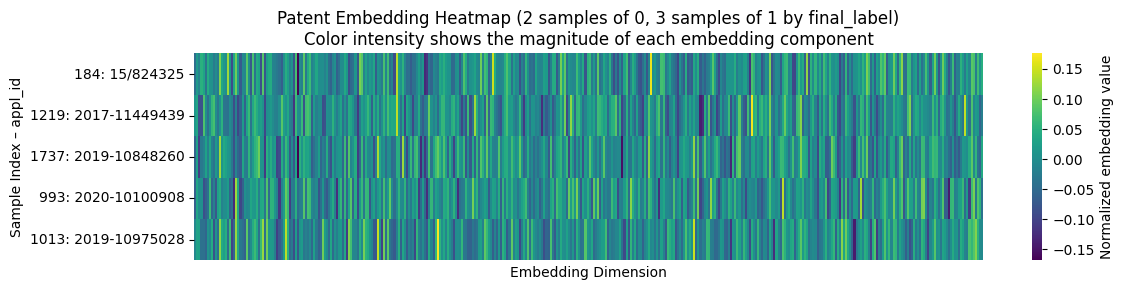

In [407]:
# ──────────── 셀 12-(9-7) 업데이트: Colorbar에 값 의미 표시 ────────────
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# reproducible RNG
rng = np.random.default_rng(42)

# 1) get indices for each label
idx0 = df_expl3.index[df_expl3["final_label"] == 0].to_numpy()
idx1 = df_expl3.index[df_expl3["final_label"] == 1].to_numpy()

# 2) sample 2 from label 0 and 3 from label 1
sel0 = rng.choice(idx0, size=2, replace=False)
sel1 = rng.choice(idx1, size=3, replace=False)
selected = np.concatenate([sel0, sel1])

# 3) extract embeddings and prepare y‑axis labels
sample_vectors = X_all[selected]  # shape = (5, embedding_dim)
yticks_labels = [
    f"{int(idx)}: {df_expl3.loc[idx, 'appl_id']}"
    for idx in selected
]

# 4) plot heatmap with colorbar label
plt.figure(figsize=(12, 3))
ax = sns.heatmap(
    sample_vectors,
    cmap="viridis",
    cbar=True,
    cbar_kws={'label': 'Normalized embedding value'},  # colorbar label added
    xticklabels=False,
    yticklabels=yticks_labels
)
ax.set_xlabel("Embedding Dimension")
ax.set_ylabel("appl_id")
ax.set_title("Patent Embedding Heatmap (2 samples of 0, 3 samples of 1 by final_label)\n"
             "Color intensity shows the magnitude of each embedding component")
plt.tight_layout()
plt.show()


In [405]:
# ──────────── 셀 12-(9-6): Cosine Similarity Matrix for Selected Samples ────────────
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

# assume `sample_vectors` and `selected` index list are defined from previous cell
# sample_vectors.shape == (5, embedding_dim)

# 1) Compute cosine similarity matrix
sim_matrix = cosine_similarity(sample_vectors)

# 2) Prepare labels for rows/columns: "index: appl_id"
labels = [f"{idx}: {df_expl3.iloc[idx]['appl_id']}" for idx in selected]

# 3) Build DataFrame for easy visualization
sim_df = pd.DataFrame(sim_matrix, index=labels, columns=labels)

# 4) Display the similarity matrix
display(sim_df)


166: 17/248078  1759: 10-2020-0004224  \
166: 17/248078               1.000000               0.003797   
1759: 10-2020-0004224        0.003797               1.000000   
619: 2018-11003629           0.031392               0.002973   
845: 2022-10836360           0.106199              -0.110377   
1321: 2016-10162470          0.074176               0.095775   

                       619: 2018-11003629  845: 2022-10836360  \
166: 17/248078                   0.031392            0.106199   
1759: 10-2020-0004224            0.002973           -0.110377   
619: 2018-11003629               1.000000            0.043685   
845: 2022-10836360               0.043685            1.000000   
1321: 2016-10162470              0.129661            0.115538   

                       1321: 2016-10162470  
166: 17/248078                    0.074176  
1759: 10-2020-0004224             0.095775  
619: 2018-11003629                0.129661  
845: 2022-10836360                0.115538  
1321: 2016-10162470               1.000000

In [390]:
print(df_expl3.columns.tolist())

['PTO_id', 'PTO_type', 'patent_kind', 'pub_type_code', 'title', 'title_en', 'abstract', 'abstract_en', 'claim_main', 'claim_main_en', 'claims_indep', 'claims_indep_en', 'num_claims', 'appl_id', 'appl_date', 'pub_id', 'pub_date', 'grant_id', 'grant_date', 'inventor', 'citations_count', 'citation_ids', 'cited_by_count', 'cited_by_ids', 'wips_family_id', 'wips_family_pub_ids', 'wips_family_pub_count', 'status_info', 'current_owner', 'num_applicants', 'applicant_nat', 'applicant_main_code', 'inventor_nat', 'num_inventors', 'cpc_main', 'cpc_all', 'ipc_main', 'ipc_all', 'orig_cpc_main', 'orig_cpc_all', 'orig_ipc_main', 'orig_ipc_all', 'wintelips_key', 'appl_date_parsed', 'year', 'country_code', 'nats_raw', 'inventor_pre', 'applicant_nat_pre', 'applicant', 'fulltext', 'seed_llm_label', 'final_label']


In [392]:
df_expl3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1861 entries, 0 to 1860
Data columns (total 54 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   PTO_id                 1861 non-null   object        
 1   PTO_type               1861 non-null   object        
 2   patent_kind            1861 non-null   object        
 3   pub_type_code          1861 non-null   object        
 4   title                  1861 non-null   object        
 5   title_en               1828 non-null   object        
 6   abstract               1861 non-null   object        
 7   abstract_en            1828 non-null   object        
 8   claim_main             1861 non-null   object        
 9   claim_main_en          1828 non-null   object        
 10  claims_indep           1861 non-null   object        
 11  claims_indep_en        1828 non-null   object        
 12  num_claims             1861 non-null   int64         
 13  appl_id 

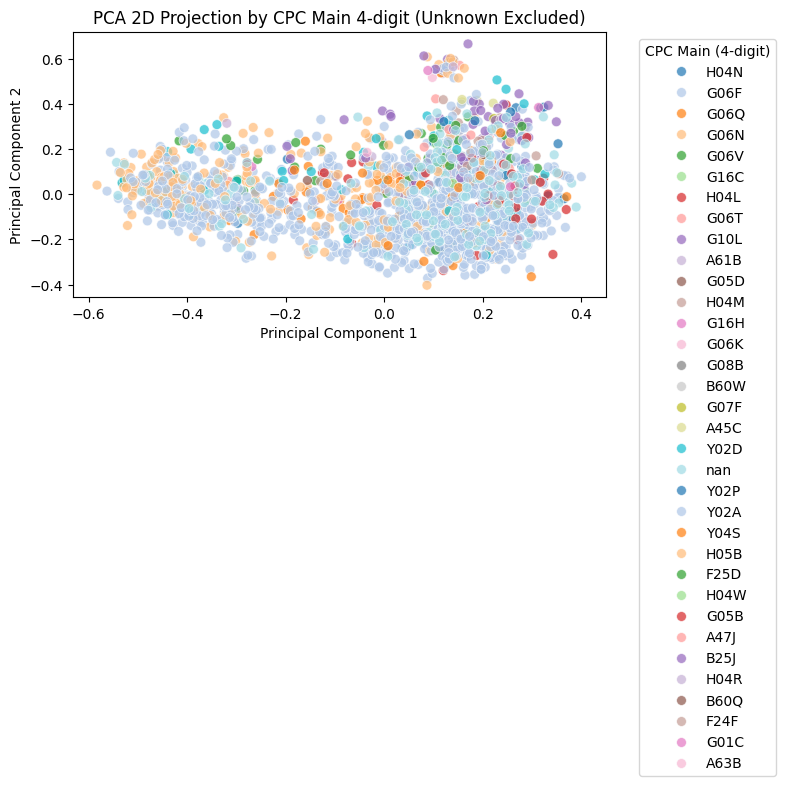

In [395]:
# ──────────── 셀 12-(9-2) cpc_main4 생성 후 2D PCA 시각화 ────────────

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import pandas as pd

# 0) cpc_main4 컬럼 생성 (cpc_main의 앞 4자리)
if "cpc_main4" not in df_expl3.columns:
    df_expl3["cpc_main4"] = df_expl3["cpc_main"].astype(str).str[:4]

# 1) PCA 투영할 전체 임베딩 X_all (이전 셀에서 계산됨)
#    X_all.shape == (문서 수, 임베딩 차원)
# 2) 'Unknown' 제외 마스크 생성
mask = df_expl3["cpc_main4"] != "Unknown"

# 3) PCA 2차원 투영
pca  = PCA(n_components=2)
X_2d = pca.fit_transform(X_all)             # 모든 문서에 대해 투영

# 4) 마스크 적용
X_fil  = X_2d[mask.values, :]               # Unknown 제외
labels = df_expl3.loc[mask, "cpc_main4"].values

# 5) 시각화용 DataFrame 생성
vis_df = pd.DataFrame({
    "PC1":       X_fil[:, 0],
    "PC2":       X_fil[:, 1],
    "cpc_main4": labels
})

# 6) 산점도 그리기
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=vis_df,
    x="PC1", y="PC2",
    hue="cpc_main4",
    palette="tab20",
    alpha=0.7,
    s=50,
    edgecolor="white"
)
plt.title("PCA 2D Projection by CPC Main 4‑digit (Unknown Excluded)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="CPC Main (4‑digit)", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


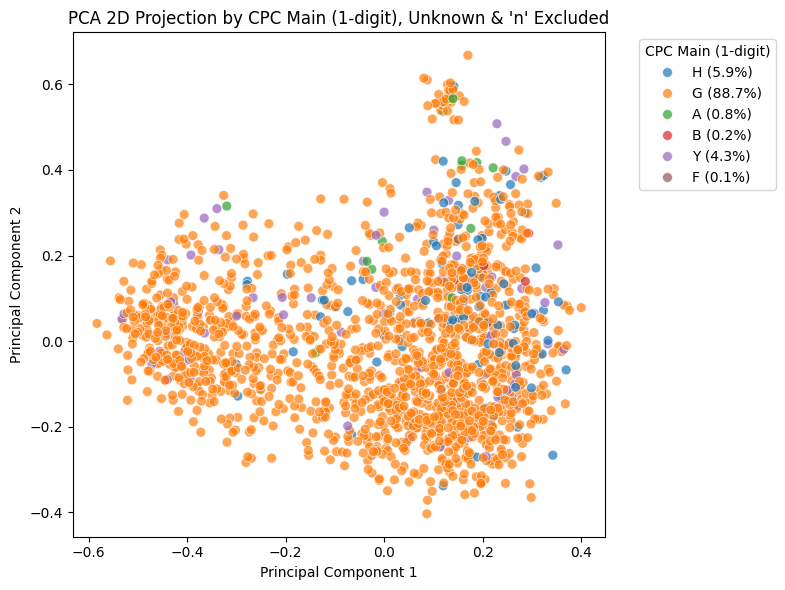

In [400]:
# ──────────── 셀 12-(9-1) 수정: 범례에 비율 표시 ────────────

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import pandas as pd

# 0) cpc_main1 생성
if "cpc_main1" not in df_expl3.columns:
    df_expl3["cpc_main1"] = df_expl3["cpc_main"].astype(str).str[:1]

# 1) Unknown 및 'n' 제외
mask = (df_expl3["cpc_main"] != "Unknown") & (df_expl3["cpc_main1"] != "n")

# 2) PCA 투영
pca  = PCA(n_components=2)
X_2d = pca.fit_transform(X_all)

# 3) 마스크 적용
X_fil   = X_2d[mask.values, :]
labels1 = df_expl3.loc[mask, "cpc_main1"].values

# 4) vis_df 생성
vis_df = pd.DataFrame({
    "PC1":       X_fil[:, 0],
    "PC2":       X_fil[:, 1],
    "cpc_main1": labels1
})

# 5) 카테고리별 비율 계산
total = len(vis_df)
counts = vis_df["cpc_main1"].value_counts().sort_index()
ratios = (counts / total * 100).round(1).astype(str) + '%'

# 6) 산점도 그리기
plt.figure(figsize=(8, 6))
ax = sns.scatterplot(
    data=vis_df,
    x="PC1", y="PC2",
    hue="cpc_main1",
    palette="tab10",
    alpha=0.7,
    s=50,
    edgecolor="white"
)

# 7) 범례 라벨에 비율 추가
handles, labels = ax.get_legend_handles_labels()
# 첫 번째 항목은 'hue' 제목이므로 건너뛰고, 실제 라벨부터 매핑
new_labels = [f"{lab} ({ratios[lab]})" if lab in ratios else lab
              for lab in labels]
ax.legend(handles, new_labels,
          title="CPC Main (1‑digit)",
          bbox_to_anchor=(1.05, 1), loc="upper left")

# 8) 마무리 레이블
plt.title("PCA 2D Projection by CPC Main (1‑digit), Unknown & 'n' Excluded")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.tight_layout()
plt.show()


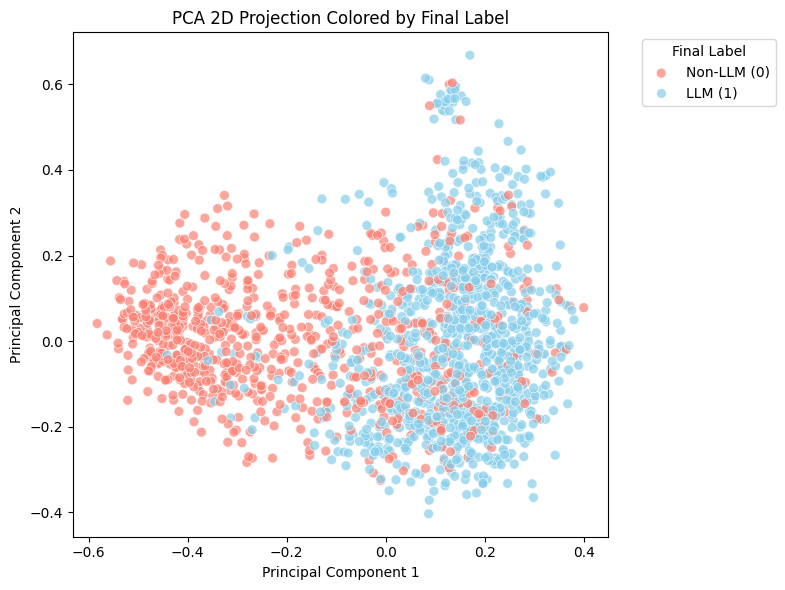

In [393]:
# ──────────── 셀 12-(9-1) 수정: final_label 로 색깔 구분 ────────────

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import pandas as pd

# 1) PCA 2차원 투영 (전체 임베딩 X_all 사용)
pca  = PCA(n_components=2)
X_2d = pca.fit_transform(X_all)             # shape = (문서 수, 2)

# 2) 시각화용 DataFrame 생성 (final_label 기준)
vis_df = pd.DataFrame({
    "PC1":        X_2d[:, 0],
    "PC2":        X_2d[:, 1],
    "final_label": df_expl3["final_label"].values
})

# 3) 산점도 그리기 (레이블별 색 구분)
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=vis_df,
    x="PC1", y="PC2",
    hue="final_label",
    palette={0: "skyblue", 1: "salmon"},
    alpha=0.7,
    s=50,
    edgecolor="white"
)
plt.title("PCA 2D Projection Colored by Final Label")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Final Label", labels=["Non-LLM (0)", "LLM (1)"],
           bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


In [408]:
# 셀 12-(10): 예측 (로지스틱 회귀 기반) + 필요 시 MLP 앙상블 후 CSV 저장

# 1) 로지스틱 확률 예측
log_proba_all = log_clf.predict_proba(X_all)[:, 1]  # LLM일 확률

# 2) MLP 앙상블 (mlp 객체가 있을 때만)
if mlp is not None:
    import torch
    with torch.no_grad():
        mlp_logits = mlp(torch.tensor(X_all, dtype=torch.float32).to(DEVICE))
        mlp_prob_all = torch.softmax(mlp_logits, dim=1)[:, 1].cpu().numpy()
    use_prob = 0.5 * log_proba_all + 0.5 * mlp_prob_all
    print("Using ensemble of Logistic + MLP")
else:
    use_prob = log_proba_all
    print("Using Logistic only")

# 3) 예측 결과 DataFrame 복사본에 저장
df_logistic = df_expl3.copy()                           # 복사본 생성

df_logistic["technology_confidence_raw"] = use_prob     # 원시 확률 저장
df_logistic["technology_type"] = np.where(
    use_prob >= 0.5, "LLM", "Others"
)  # 0.5 기준 분류



Using ensemble of Logistic + MLP


In [409]:
# CSV로 저장 (df_logistic)
filename = r"G:\My Drive\data1\df_logistic_classification.csv"
df_logistic.to_csv(filename, index=False, encoding="utf-8-sig")
print(f"Saved classified data to {filename}")

Saved classified data to G:\My Drive\data1\df_logistic_classification.csv


In [410]:
# technology_type별 count와 ratio 간단히 표시
df = df_logistic["technology_type"].value_counts().to_frame("count")
df["ratio"] = (df["count"] / len(df_logistic)).round(3)
df

count  ratio
technology_type              
Others            1148  0.617
LLM                713  0.383

<Axes: ylabel='Frequency'>

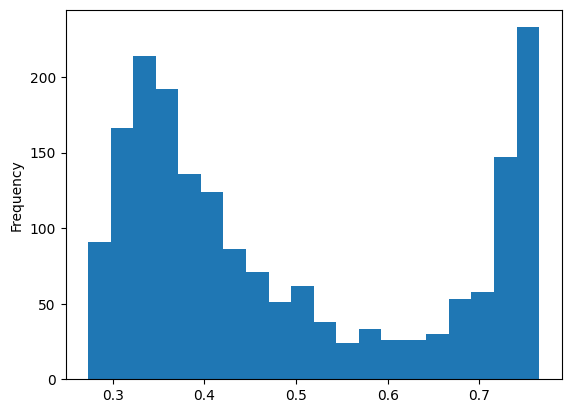

In [411]:
# (수치형일 경우 구간 빈도 보고 싶으면)
df_logistic["technology_confidence_raw"].plot.hist(bins=20)

In [412]:
df_logistic.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1861 entries, 0 to 1860
Data columns (total 57 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   PTO_id                     1861 non-null   object        
 1   PTO_type                   1861 non-null   object        
 2   patent_kind                1861 non-null   object        
 3   pub_type_code              1861 non-null   object        
 4   title                      1861 non-null   object        
 5   title_en                   1828 non-null   object        
 6   abstract                   1861 non-null   object        
 7   abstract_en                1828 non-null   object        
 8   claim_main                 1861 non-null   object        
 9   claim_main_en              1828 non-null   object        
 10  claims_indep               1861 non-null   object        
 11  claims_indep_en            1828 non-null   object        
 12  num_claims 

In [413]:
# 셀 12-(11): Threshold 최적화 및 최적화 결과 저장

from sklearn.metrics import f1_score   # F1 함수
import numpy as np

# 1) 후보 임계값 리스트
thresholds = np.linspace(0.1, 0.9, 33)   # 0.1~0.9 구간 33개

# 2) 검증 확률 선택 (Logistic 또는 앙상블)
valid_ref_prob = (
    log_clf.predict_proba(X_valid)[:,1]
    if mlp is None
    else 0.5 * valid_proba + 0.5 * mlp_val_prob
)

# 3) 최적 threshold 탐색 (Macro F1 최대화)
best_t, best_f1 = 0.5, -1
for t in thresholds:
    preds_t = (valid_ref_prob >= t).astype(int)
    f1_t = f1_score(y_valid, preds_t, average="macro")
    if f1_t > best_f1:
        best_f1, best_t = f1_t, t

print(f"Best threshold on validation: {best_t:.3f} (F1={best_f1:.4f})")

# 4) df_logistic 복사본에 최적 threshold 적용
df_logistic_tuned = df_logistic.copy()  # 원본 보존

df_logistic_tuned["technology_type"] = np.where(
    df_logistic_tuned["technology_confidence_raw"] >= best_t,
    "LLM",
    "Others"
)
df_logistic_tuned["technology_confidence"] = df_logistic_tuned["technology_confidence_raw"]



Best threshold on validation: 0.500 (F1=0.8539)


In [414]:
# 5) CSV로 저장 (tuned)
filename = r"G:\My Drive\data1\df_logistic_tuned_classification.csv"
df_logistic_tuned.to_csv(filename, index=False, encoding="utf-8-sig")
print(f"Saved tuned results to {filename}")

Saved tuned results to G:\My Drive\data1\df_logistic_tuned_classification.csv


In [415]:
# 셀 12-(12): 기존(0.5) vs 최적 임계치(best_t) 성능 비교 출력

from sklearn.metrics import accuracy_score, recall_score, f1_score
import pandas as pd

# 1) 확률 벡터 준비 (모델 또는 앙상블)
probs = (
    log_clf.predict_proba(X_valid)[:,1]
    if mlp is None
    else 0.5*valid_proba + 0.5*mlp_val_prob
)

# 2) 기존 임계치(0.5) 예측
orig_t = 0.5                                            # 기존 threshold
pred_orig = (probs >= orig_t).astype(int)               # 0.5 기준 예측
acc_orig = accuracy_score(y_valid, pred_orig)           # 정확도
rec_orig = recall_score(y_valid, pred_orig, average='macro')  # 매크로 리콜
f1_orig  = f1_score(y_valid, pred_orig, average='macro')      # 매크로 F1

# 3) 최적 임계치(best_t) 예측
tun_t = best_t                                          # 튜닝된 threshold
pred_tuned = (probs >= tun_t).astype(int)               # 최적 threshold 예측
acc_tuned = accuracy_score(y_valid, pred_tuned)         # 튜닝 정확도
rec_tuned = recall_score(y_valid, pred_tuned, average='macro')# 튜닝 리콜
f1_tuned  = f1_score(y_valid, pred_tuned, average='macro')   # 튜닝 F1

# 4) 결과를 DataFrame으로 정리
df_compare = pd.DataFrame({
    'threshold': [orig_t, tun_t],
    'accuracy':  [acc_orig, acc_tuned],
    'recall':    [rec_orig, rec_tuned],
    'f1_score':  [f1_orig, f1_tuned]
}, index=['original','tuned'])

# 5) 출력
print("Threshold 최적화 전후 성능 비교")
print(df_compare.round(3))


Threshold 최적화 전후 성능 비교
          threshold  accuracy  recall  f1_score
original        0.5     0.861   0.847     0.854
tuned           0.5     0.861   0.847     0.854


In [416]:
# technology_type별 count와 ratio 간단히 표시
df = df_logistic_tuned["technology_type"].value_counts().to_frame("count")
df["ratio"] = (df["count"] / len(df_logistic_tuned)).round(3)
df

count  ratio
technology_type              
Others            1148  0.617
LLM                713  0.383

In [417]:
# 셀 12-(14): 결과 저장 (CSV) — 모든 컬럼 포함, 고정 파일명

import os

out_base = base_dir if 'base_dir' in globals() else '.'
filename = "df_logistic_tuned.csv"                       # 고정된 파일명 지정
out_path = os.path.join(out_base, filename)

df_logistic_tuned.to_csv(out_path, index=False, encoding="utf-8-sig")  # 바로 저장
print("저장 완료:", out_path)


저장 완료: /content/drive/My Drive/data1/df_logistic_tuned.csv


In [418]:
# 셀 12-(17): Seed vs Model 합의율 비교 (튜닝 전·후)

import numpy as np
from sklearn.model_selection import train_test_split

# 1) 유효 인덱스 및 stratify용 레이블 추출 (df_logistic 기준)
mask0    = df_logistic[["fulltext","final_label"]].notnull().all(axis=1)
idx_all0 = df_logistic.index[mask0]
y0       = df_logistic.loc[idx_all0, "final_label"]

# 2) 재분할하여 valid 인덱스 획득
_, valid_idx0 = train_test_split(idx_all0, test_size=0.1, random_state=42, stratify=y0)

# 3) 튜닝 전 합의율 계산 (threshold=0.5 기준)
seed0 = df_logistic.loc[valid_idx0, "final_label"].map({0:"Others",1:"LLM"}).reset_index(drop=True)
pred0 = df_logistic.loc[valid_idx0, "technology_type"].reset_index(drop=True)
agree0 = (seed0 == pred0).mean()

# 4) 유효 인덱스 및 stratify용 레이블 추출 (df_logistic_tuned 기준)
mask1    = df_logistic_tuned[["fulltext","final_label"]].notnull().all(axis=1)
idx_all1 = df_logistic_tuned.index[mask1]
y1       = df_logistic_tuned.loc[idx_all1, "final_label"]

# 5) 동일 재분할하여 valid 인덱스 획득
_, valid_idx1 = train_test_split(idx_all1, test_size=0.1, random_state=42, stratify=y1)

# 6) 튜닝 후 합의율 계산 (best_t 기준)
seed1 = df_logistic_tuned.loc[valid_idx1, "final_label"].map({0:"Others",1:"LLM"}).reset_index(drop=True)
pred1 = df_logistic_tuned.loc[valid_idx1, "technology_type"].reset_index(drop=True)
agree1 = (seed1 == pred1).mean()

# 7) 출력 비교
print("Seed vs Model Agreement Comparison")
print(f"{'Setting':<15}{'Agreement':>12}")
print(f"{'-'*27}")
print(f"{'Original (t=0.5)':<15}{agree0:>12.3f}")
print(f"{f'Tuned (t={best_t:.3f})':<15}{agree1:>12.3f}")


Seed vs Model Agreement Comparison
Setting           Agreement
---------------------------
Original (t=0.5)       0.861
Tuned (t=0.500)       0.861


In [419]:
# 셀 12-(18): 낮은 확률 LLM 보수적 재분류 (precision↑ 목적)

THRESH = 0.6  # confidence 임계값
df_conservative = df_logistic_tuned.copy()  # 재분류 전 상태 보존

# 1) 원래 LLM으로 예측됐으나 confidence<THRESH인 샘플 식별
mask_low = (df_conservative["technology_type"] == "LLM") & \
           (df_conservative["technology_confidence_raw"] < THRESH)

# 2) 보수 재분류: 불확실 LLM → Others
df_conservative.loc[mask_low, "technology_type"] = "Others"

# 3) 재분류 전·후 LLM 비율 비교
total = len(df_conservative)
before = (df_logistic_tuned["technology_type"] == "LLM").sum()
after  = (df_conservative["technology_type"] == "LLM").sum()

print("=== LLM 보수적 재분류 결과 ===")
print(f"Threshold            : {THRESH}")
print(f"LLM count before     : {before} / {total} ({before/total:.1%})")
print(f"LLM count after      : {after} / {total} ({after/total:.1%})")
print(f"재분류 건수 (LLM→Others): {mask_low.sum()}")


=== LLM 보수적 재분류 결과 ===
Threshold            : 0.6
LLM count before     : 713 / 1861 (38.3%)
LLM count after      : 566 / 1861 (30.4%)
재분류 건수 (LLM→Others): 147


In [420]:
df_conservative.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1861 entries, 0 to 1860
Data columns (total 58 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   PTO_id                     1861 non-null   object        
 1   PTO_type                   1861 non-null   object        
 2   patent_kind                1861 non-null   object        
 3   pub_type_code              1861 non-null   object        
 4   title                      1861 non-null   object        
 5   title_en                   1828 non-null   object        
 6   abstract                   1861 non-null   object        
 7   abstract_en                1828 non-null   object        
 8   claim_main                 1861 non-null   object        
 9   claim_main_en              1828 non-null   object        
 10  claims_indep               1861 non-null   object        
 11  claims_indep_en            1828 non-null   object        
 12  num_claims 

In [421]:
df_conservative["technology_type"].value_counts()

technology_type
Others    1295
LLM        566
Name: count, dtype: int64

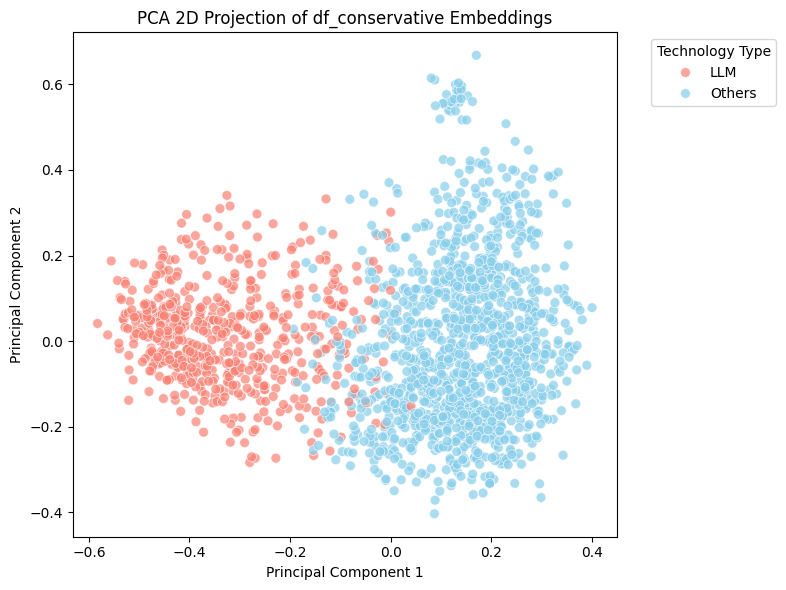

In [422]:
# ──────────── 셀 12-(10): df_conservative Embedding PCA 2D Projection ────────────
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import pandas as pd

# 1) Extract fulltexts and compute embeddings
cons_texts = df_conservative["fulltext"].tolist()
X_cons = encode_texts(cons_texts, batch_size=64)

# 2) PCA 2D projection
pca_cons = PCA(n_components=2)
X2_cons = pca_cons.fit_transform(X_cons)

# 3) Build visualization DataFrame
vis_cons = pd.DataFrame({
    "PC1": X2_cons[:, 0],
    "PC2": X2_cons[:, 1],
    "technology_type": df_conservative["technology_type"].values
})

# 4) Scatterplot colored by technology_type
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=vis_cons,
    x="PC1", y="PC2",
    hue="technology_type",
    palette={"Others": "skyblue", "LLM": "salmon"},
    alpha=0.7,
    s=50,
    edgecolor="white"
)
plt.title("PCA 2D Projection of df_conservative Embeddings")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Technology Type", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


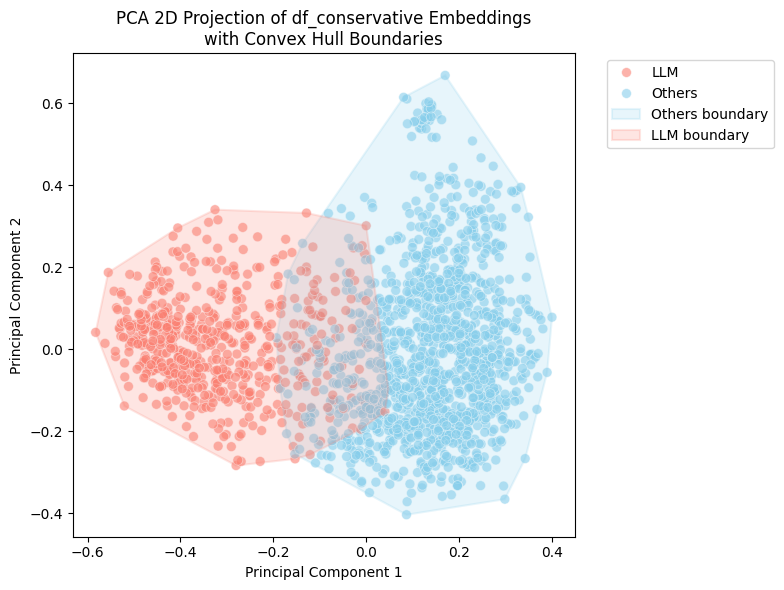

In [423]:
# ──────────── 셀 12-(10-1): PCA 2D Projection with Convex Hull Boundaries ────────────
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.spatial import ConvexHull
from sklearn.decomposition import PCA

# 1) Compute embeddings for df_conservative (if not already done)
cons_texts = df_conservative["fulltext"].tolist()
X_cons = encode_texts(cons_texts, batch_size=64)

# 2) PCA 2D projection
pca_cons = PCA(n_components=2)
X2_cons = pca_cons.fit_transform(X_cons)

# 3) Prepare DataFrame
vis_cons = pd.DataFrame({
    "PC1": X2_cons[:, 0],
    "PC2": X2_cons[:, 1],
    "technology_type": df_conservative["technology_type"].values
})

# 4) Scatterplot
plt.figure(figsize=(8, 6))
ax = sns.scatterplot(
    data=vis_cons,
    x="PC1", y="PC2",
    hue="technology_type",
    palette={"Others": "skyblue", "LLM": "salmon"},
    alpha=0.6,
    s=50,
    edgecolor="white"
)

# 5) Draw convex hulls for each category
for tech, color in {"Others": "skyblue", "LLM": "salmon"}.items():
    pts = vis_cons.loc[vis_cons["technology_type"] == tech, ["PC1", "PC2"]].values
    if pts.shape[0] >= 3:
        hull = ConvexHull(pts)
        hull_pts = pts[hull.vertices]
        # fill polygon with slight transparency
        ax.fill(
            hull_pts[:, 0], hull_pts[:, 1],
            alpha=0.2, facecolor=color, edgecolor=color, linewidth=1.5,
            label=f"{tech} boundary"
        )

# 6) Legend and labels
handles, labels = ax.get_legend_handles_labels()
# To avoid duplicate legend entries
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.05, 1), loc="upper left")

plt.title("PCA 2D Projection of df_conservative Embeddings\nwith Convex Hull Boundaries")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.tight_layout()
plt.show()


In [424]:
# ──────────── 셀 12-(11): Filter LLM items and save to CSV ────────────

# 1) Filter rows where technology_type is 'LLM'
llm_df = df_conservative[df_conservative["technology_type"] == "LLM"].reset_index(drop=True)

# 2) Save to CSV (adjust the path as needed)
output_path = "df_conservative_LLM_only.csv"
llm_df.to_csv(output_path, index=False, encoding="utf-8-sig")

print(f"Saved {len(llm_df)} LLM entries to {output_path}")


Saved 566 LLM entries to df_conservative_LLM_only.csv


In [425]:
llm_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 566 entries, 0 to 565
Data columns (total 58 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   PTO_id                     566 non-null    object        
 1   PTO_type                   566 non-null    object        
 2   patent_kind                566 non-null    object        
 3   pub_type_code              566 non-null    object        
 4   title                      566 non-null    object        
 5   title_en                   566 non-null    object        
 6   abstract                   566 non-null    object        
 7   abstract_en                566 non-null    object        
 8   claim_main                 566 non-null    object        
 9   claim_main_en              566 non-null    object        
 10  claims_indep               566 non-null    object        
 11  claims_indep_en            566 non-null    object        
 12  num_clai

In [433]:
df_network.shape

(1861, 50)

In [432]:
df_network.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1861 entries, 0 to 1860
Data columns (total 50 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   PTO_id                 1861 non-null   object        
 1   PTO_type               1861 non-null   object        
 2   patent_kind            1861 non-null   object        
 3   pub_type_code          1861 non-null   object        
 4   title                  1861 non-null   object        
 5   title_en               1828 non-null   object        
 6   abstract               1861 non-null   object        
 7   abstract_en            1828 non-null   object        
 8   claim_main             1861 non-null   object        
 9   claim_main_en          1828 non-null   object        
 10  claims_indep           1861 non-null   object        
 11  claims_indep_en        1828 non-null   object        
 12  num_claims             1861 non-null   int64         
 13  appl_id 

In [474]:
# ──────────── 셀 12-(12c): Filter df_network by LLM appl_id list ────────────

# 1) Extract unique appl_id for LLM patents
llm_appl_ids = llm_df.loc[llm_df["technology_type"] == "LLM", "appl_id"].unique().tolist()

# 2) Filter the existing df_network DataFrame
#    (assumes df_network has a column 'appl_id' indicating which patent each edge/node belongs to)
df_network_llm = df_network[df_network["appl_id"].isin(llm_appl_ids)].copy()

# 3) (Optional) inspect the filtered network
print(f"Filtered network contains {df_network_llm.shape[0]} rows and {df_network_llm.shape[1]} columns")
df_network_llm.head()


Filtered network contains 2279 rows and 50 columns


PTO_id PTO_type patent_kind pub_type_code  \
0     US       US           P            B1   
0     US       US           P            B1   
0     US       US           P            B1   
0     US       US           P            B1   
0     US       US           P            B1   

                                               title  \
0  Interactive sentiment-detecting video streamin...   
0  Interactive sentiment-detecting video streamin...   
0  Interactive sentiment-detecting video streamin...   
0  Interactive sentiment-detecting video streamin...   
0  Interactive sentiment-detecting video streamin...   

                     title_en  \
0  대화형 감정 검출 비디오 스트리밍 시스템과 방법   
0  대화형 감정 검출 비디오 스트리밍 시스템과 방법   
0  대화형 감정 검출 비디오 스트리밍 시스템과 방법   
0  대화형 감정 검출 비디오 스트리밍 시스템과 방법   
0  대화형 감정 검출 비디오 스트리밍 시스템과 방법   

                                            abstract  \
0  Embodiments of the systems, methods, and compu...   
0  Embodiments of the systems, methods, and compu...   
0  Embodiments of the systems, methods, and compu...   
0  Embodiments of the systems, methods, and compu...   
0  Embodiments of the systems, methods, and compu...   

                                         abstract_en  \
0  시스템, 방법, 여기에 개시된 컴퓨터 판독 가능 매체 장치는 장치로부터 수신된 사용...   
0  시스템, 방법, 여기에 개시된 컴퓨터 판독 가능 매체 장치는 장치로부터 수신된 사용...   
0  시스템, 방법, 여기에 개시된 컴퓨터 판독 가능 매체 장치는 장치로부터 수신된 사용...   
0  시스템, 방법, 여기에 개시된 컴퓨터 판독 가능 매체 장치는 장치로부터 수신된 사용...   
0  시스템, 방법, 여기에 개시된 컴퓨터 판독 가능 매체 장치는 장치로부터 수신된 사용...   

                                          claim_main  \
0  1. A video streaming system comprising: one or...   
0  1. A video streaming system comprising: one or...   
0  1. A video streaming system comprising: one or...   
0  1. A video streaming system comprising: one or...   
0  1. A video streaming system comprising: one or...   

                                       claim_main_en  ...  orig_ipc_main  \
0  1. 다음을 포함하는 비디오 스트리밍 시스템. 저장하도록 구성된 하나 이상의 데이터...  ...  H04N-021/8545   
0  1. 다음을 포함하는 비디오 스트리밍 시스템. 저장하도록 구성된 하나 이상의 데이터...  ...  H04N-021/8545   
0  1. 다음을 포함하는 비디오 스트리밍 시스템. 저장하도록 구성된 하나 이상의 데이터...  ...  H04N-021/8545   
0  1. 다음을 포함하는 비디오 스트리밍 시스템. 저장하도록 구성된 하나 이상의 데이터...  ...  H04N-021/8545   
0  1. 다음을 포함하는 비디오 스트리밍 시스템. 저장하도록 구성된 하나 이상의 데이터...  ...  H04N-021/8545   

                                        orig_ipc_all  wintelips_key  \
0  H04N-021/8545 | G06T-011/20 | H04N-021/2187 | ...  4920015007499   
0  H04N-021/8545 | G06T-011/20 | H04N-021/2187 | ...  4920015007499   
0  H04N-021/8545 | G06T-011/20 | H04N-021/2187 | ...  4920015007499   
0  H04N-021/8545 | G06T-011/20 | H04N-021/2187 | ...  4920015007499   
0  H04N-021/8545 | G06T-011/20 | H04N-021/2187 | ...  4920015007499   

  appl_date_parsed  year country_code  \
0       2019-02-22  2019           US   
0       2019-02-22  2019           US   
0       2019-02-22  2019           US   
0       2019-02-22  2019           US   
0       2019-02-22  2019           US   

                                           nats_raw       inventor_pre  \
0  [US, US, US, US, US, US, US, US, US, US, US, US]  Nicholas  Pontiff   
0  [US, US, US, US, US, US, US, US, US, US, US, US]           John  Li   
0  [US, US, US, US, US, US, US, US, US, US, US, US]  Stephen  Kirkland   
0  [US, US, US, US, US, US, US, US, US, US, US, US]     Brian  Drehoff   
0  [US, US, US, US, US, US, US, US, US, US, US, US]       David  Cyman   

  applicant_nat_pre             applicant  
0                US  HALOGEN NETWORKS LLC  
0                US  HALOGEN NETWORKS LLC  
0                US  HALOGEN NETWORKS LLC  
0                US  HALOGEN NETWORKS LLC  
0                US  HALOGEN NETWORKS LLC  

[5 rows x 50 columns]

In [475]:
df_network_llm.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2279 entries, 0 to 1860
Data columns (total 50 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   PTO_id                 2279 non-null   object        
 1   PTO_type               2279 non-null   object        
 2   patent_kind            2279 non-null   object        
 3   pub_type_code          2279 non-null   object        
 4   title                  2279 non-null   object        
 5   title_en               2279 non-null   object        
 6   abstract               2279 non-null   object        
 7   abstract_en            2279 non-null   object        
 8   claim_main             2279 non-null   object        
 9   claim_main_en          2279 non-null   object        
 10  claims_indep           2279 non-null   object        
 11  claims_indep_en        2279 non-null   object        
 12  num_claims             2279 non-null   int64         
 13  appl_id 

In [476]:
# Display only the specified columns
df_network_llm[['appl_id', 'year', 'inventor', 'inventor_nat', 'country_code']]

appl_id  year          inventor inventor_nat country_code
0         16/283492  2019  NICHOLAS PONTIFF           US           US
0         16/283492  2019           JOHN LI           US           US
0         16/283492  2019  STEPHEN KIRKLAND           US           US
0         16/283492  2019     BRIAN DREHOFF           US           US
0         16/283492  2019       DAVID CYMAN           US           US
...             ...   ...               ...          ...          ...
1859  2014-10006867  2014          REN FUJI           CN           CN
1860  2013-10701519  2013      NIU ZHENDONG           CN           CN
1860  2013-10701519  2013       HUANG SHENG           CN           CN
1860  2013-10701519  2013           LIU SHA           CN           CN
1860  2013-10701519  2013          CHEN JIE           CN           CN

[2279 rows x 5 columns]

In [477]:
# Filter for a specific appl_id and then select & sort
df_llm_info_specific = (
    df_network_llm[df_network_llm['appl_id'] == '16/283492']
    [['appl_id', 'year', 'inventor', 'inventor_nat', 'country_code']]
    .sort_values('appl_id')
    .reset_index(drop=True)
)
df_llm_info_specific


appl_id  year                  inventor inventor_nat country_code
0   16/283492  2019          NICHOLAS PONTIFF           US           US
1   16/283492  2019                   JOHN LI           US           US
2   16/283492  2019          STEPHEN KIRKLAND           US           US
3   16/283492  2019             BRIAN DREHOFF           US           US
4   16/283492  2019               DAVID CYMAN           US           US
5   16/283492  2019                HENRY PATE           US           US
6   16/283492  2019         JACOB QUATTROCCHI           US           US
7   16/283492  2019            TIMOTHY ASHLEY           US           US
8   16/283492  2019              DWIGHT DOANE           US           US
9   16/283492  2019  PATRICK FRANCIS MATTHEWS           US           US
10  16/283492  2019      JOSEPH AUSTIN MUSICE           US           US
11  16/283492  2019      THOMAS STEVEN MILLER           US           US

In [487]:
#여기부터 network analysis

In [488]:
# ──────────── 셀 12-(12c): 공동발명 네트워크 생성 및 엣지 가중치 계산 (LLM 특허, 2004–2016) ────────────
import networkx as nx   # 네트워크 생성·분석용

# 1) 분석 기간 설정: 2000~2018 (예시)
year_sel = list(range(2000, 2018))

# 2) 출원별(unique) 발명자 리스트 추출
#    - df_network_llm에서 연도 필터 적용
#    - groupby + unique()로 중복 발명자 제거
inventors_per_patent = (
    df_network_llm[df_network_llm['year'].isin(year_sel)]
        .groupby('appl_id')['inventor']
        .agg(lambda x: x.unique().tolist())
)

# 3) 네트워크(G) 생성 및 엣지 추가
#    - 2인 조합별 엣지 생성, 이미 존재하면 weight += 1
G_llm = nx.Graph()
for inv_list in inventors_per_patent:
    if len(inv_list) < 2:
        continue  # 단독 출원 건은 제외
    for i, a in enumerate(inv_list):
        for b in inv_list[i+1:]:
            if G_llm.has_edge(a, b):
                G_llm[a][b]['weight'] += 1
            else:
                G_llm.add_edge(a, b, weight=1)

# 4) 노드 수 제한: degree 기준 상위 150개 추출
no_nodes = 300
deg_dict = dict(G_llm.degree(weight='weight'))
top_nodes = sorted(deg_dict, key=deg_dict.get, reverse=True)[:no_nodes]
G_sub = G_llm.subgraph(top_nodes).copy()

# 5) 결과 요약 출력: 노드/엣지 수 확인
print(f"▶︎ LLM 서브그래프 노드 수: {G_sub.number_of_nodes()}, 엣지 수: {G_sub.number_of_edges()}")


▶︎ LLM 서브그래프 노드 수: 300, 엣지 수: 750


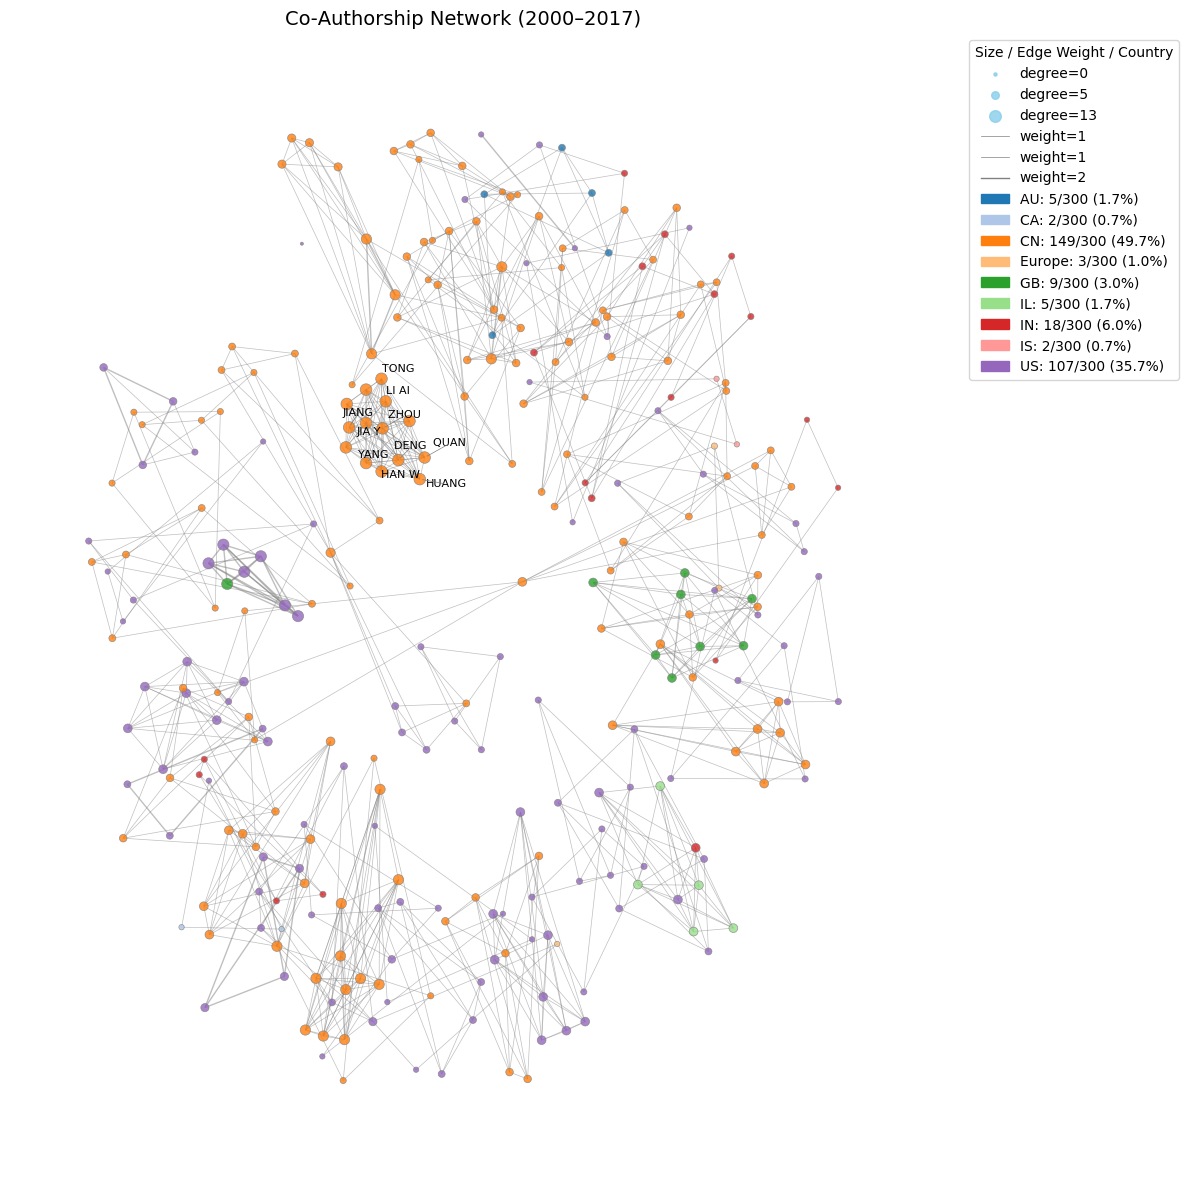

In [489]:
# ──────────── 셀 12-(12d): Co‑Authorship Network 시각화 (no cutoff, thinner edges + legend) ────────────
import matplotlib.pyplot as plt
import networkx as nx
from adjustText import adjust_text
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import seaborn as sns

# (1) G_sub은 이미 상위 150 노드로 한 번 서브그래프된 상태
G2 = G_sub  # 컷오프 없이 그대로 사용

# (2) 레이아웃
pos = nx.spring_layout(G2, k=0.2, iterations=20, seed=42)

# (3) node 크기 & edge 굵기 (thinner)
deg = dict(G2.degree(weight='weight'))
node_sizes = [(deg[n]+1)*5 for n in G2.nodes()]
weights = [G2[u][v]['weight'] for u,v in G2.edges()]
edge_widths = [w/max(weights)*1.0 for w in weights] if weights else []

# (4) 국가별 그룹핑 (EU 묶기)
EU = {"AT","BE","BG","HR","CY","CZ","DK","EE","FI","FR","DE","GR",
      "HU","IE","IT","LV","LT","LU","MT","NL","PL","PT","RO","SK","SI","ES","SE"}
nat_map = {n: df_network_llm.loc[df_network_llm['inventor']==n,'inventor_nat'].iloc[0]
           for n in G2.nodes()}
group_map = {n: ('Europe' if nat_map[n] in EU else nat_map[n]) for n in G2.nodes()}

# (5) 팔레트 준비
groups = sorted(set(group_map.values()))
palette = sns.color_palette('tab20', len(groups))
color_map = dict(zip(groups, palette))
node_colors = [color_map[group_map[n]] for n in G2.nodes()]

# (6) 그리기
plt.figure(figsize=(12,12))
nx.draw_networkx_edges(G2, pos, width=edge_widths, edge_color='gray', alpha=0.5)
nx.draw_networkx_nodes(G2, pos,
                       node_size=node_sizes,
                       node_color=node_colors,
                       linewidths=0.5, edgecolors='grey', alpha=0.8)

# (7) 상위 10명 이름 5자 제한하여 라벨링
top10 = sorted(deg, key=deg.get, reverse=True)[:10]
labels = {n: n[:5] for n in top10}
texts = [plt.text(*pos[n], labels[n], fontsize=8) for n in labels]
adjust_text(texts, expand_points=(1.1,1.1),
            arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))

# (8) 범례 구성
total = len(G2)
size_vals = [min(deg.values()), int(sum(deg.values())/total), max(deg.values())]
size_handles = [plt.scatter([],[], s=(d+1)*5, color='skyblue', alpha=0.8) for d in size_vals]
size_labels = [f'degree={d}' for d in size_vals]
edge_vals = [min(weights), int(sum(weights)/len(weights)), max(weights)]
edge_handles = [mlines.Line2D([], [], color='gray', linewidth=w/max(weights)*1.0,
                              label=f"weight={w}") for w in edge_vals]
group_counts = {g: sum(1 for n in G2 if group_map[n]==g) for g in groups}
group_handles = [mpatches.Patch(color=color_map[g],
                                label=f"{g}: {group_counts[g]}/{total} ({group_counts[g]/total:.1%})")
                 for g in groups]

plt.legend(size_handles + edge_handles + group_handles,
           size_labels + [f"weight={w}" for w in edge_vals] + [h.get_label() for h in group_handles],
           title='Size / Edge Weight / Country',
           bbox_to_anchor=(1.05,1), loc='upper left')

plt.axis('off')
plt.title(f'Co‑Authorship Network ({year_sel[0]}–{year_sel[-1]})', fontsize=14)
plt.tight_layout()
plt.show()


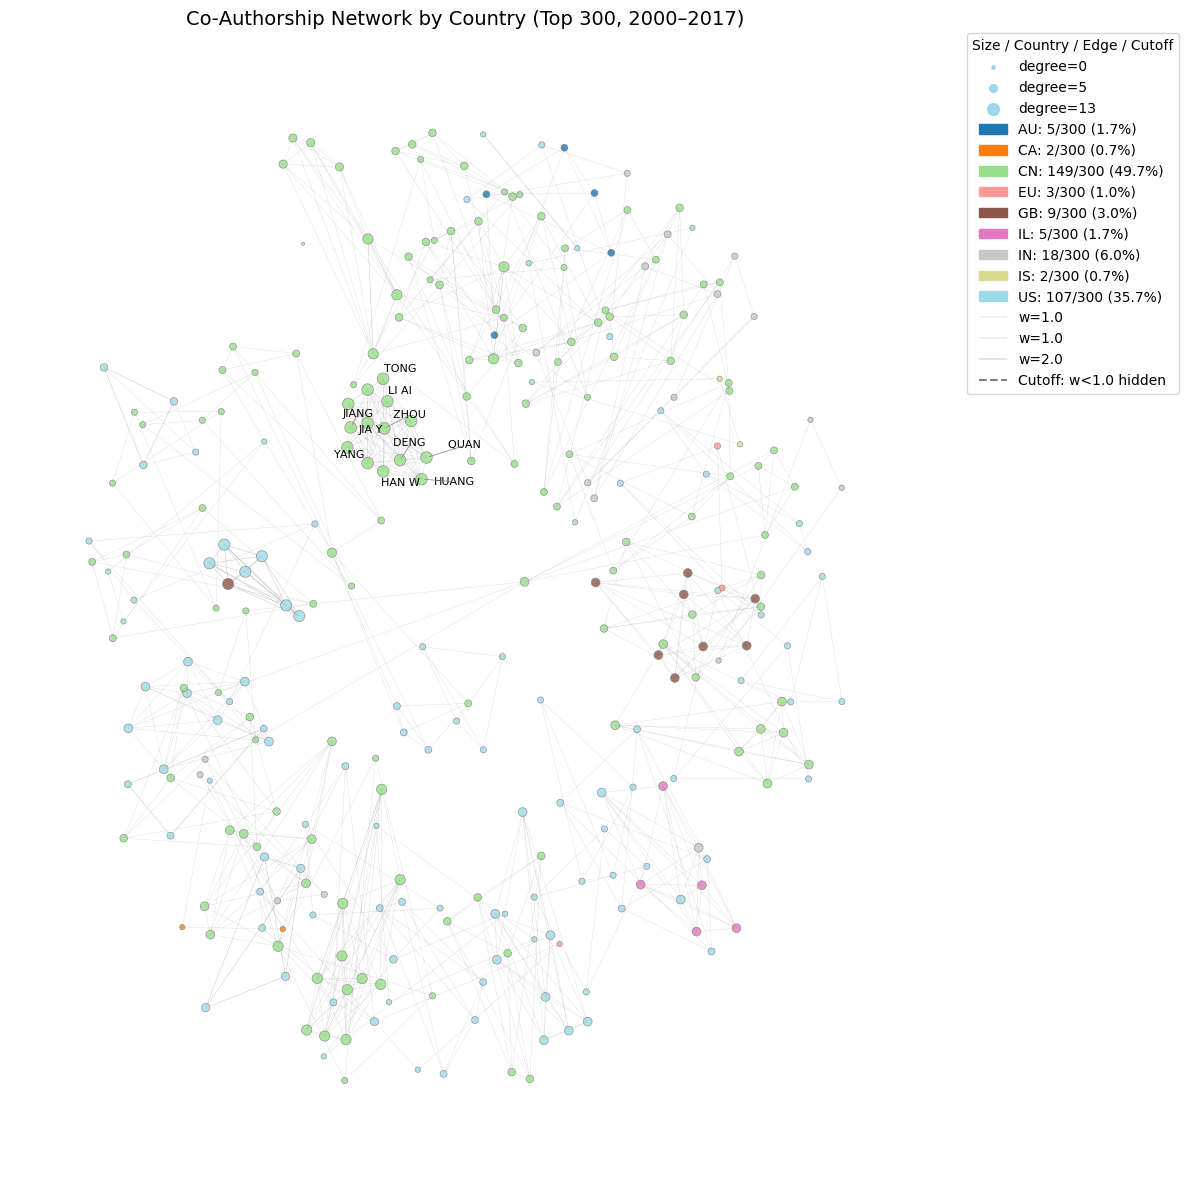

In [490]:
# ──────────── 셀 12-(12e): Co‑Authorship Network 시각화 (extra thin edges + legend) ────────────
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.cm as cm
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from adjustText import adjust_text
import seaborn as sns
import pandas as pd

# 0) Use the weighted graph G_llm built earlier and subgraph G_sub of top nodes
G = G_sub

# 1) Compute degrees, node sizes
deg = dict(G.degree(weight="weight"))
nodes = list(G.nodes())
node_sizes = [(deg[n] + 1) * 5 for n in nodes]

# 2) Edge filter and super-thin widths
threshold = 1.0
raw_edges = [(u, v, d["weight"]) for u, v, d in G.edges(data=True)]
filtered = [(u, v, w) for u, v, w in raw_edges if w >= threshold]
edgelist = [(u, v) for u, v, w in filtered]
max_w = max((w for _, _, w in filtered), default=1)
edge_widths = [w / max_w * 0.3 for _, _, w in filtered]  # scale to 0.3 for very thin lines

# 3) Map inventors to countries (EU grouped)
EU_CODES = {
    "AT","BE","BG","HR","CY","CZ","DK","EE","FI","FR","DE","GR",
    "HU","IE","IT","LV","LT","LU","MT","NL","PL","PT","RO",
    "SK","SI","ES","SE"
}
nat_map = {n: df_network_llm.loc[df_network_llm['inventor']==n, 'inventor_nat'].iloc[0] for n in nodes}
group_map = {
    n: ('EU' if nat_map[n] in EU_CODES else 'GB' if nat_map[n]=='GB' else nat_map[n] or 'UN')
    for n in nodes
}

# 4) Color palette
groups = sorted(set(group_map.values()))
cmap = cm.get_cmap('tab20', len(groups))
color_map = {g: cmap(i) for i, g in enumerate(groups)}
node_colors = [color_map[group_map[n]] for n in nodes]

# 5) Layout
pos = nx.spring_layout(G, k=0.2, iterations=20, seed=42)

# 6) Draw edges and nodes
plt.figure(figsize=(12,12))
nx.draw_networkx_edges(G, pos,
                       edgelist=edgelist,
                       width=edge_widths,
                       edge_color='gray',
                       alpha=0.5)
nx.draw_networkx_nodes(G, pos,
                       nodelist=nodes,
                       node_size=node_sizes,
                       node_color=node_colors,
                       linewidths=0.5,
                       edgecolors='grey',
                       alpha=0.8)

# 7) Label top 10 inventors (first 5 chars)
top10 = sorted(deg, key=deg.get, reverse=True)[:10]
texts = [plt.text(*pos[n], n[:5], fontsize=8) for n in top10]
adjust_text(texts,
            expand_text=(1.5,1.5), expand_points=(2,2),
            force_text=(0.5,0.5), force_points=(0.2,0.2),
            arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))

# 8) Build legend
total_nodes = len(nodes)
# Node size legend
deg_min, deg_avg, deg_max = min(deg.values()), int(sum(deg.values())/total_nodes), max(deg.values())
size_handles = [plt.scatter([],[], s=(d+1)*5, color='skyblue', alpha=0.8) for d in (deg_min, deg_avg, deg_max)]
size_labels  = [f'degree={d}' for d in (deg_min, deg_avg, deg_max)]
# Country legend
group_counts = {g: sum(1 for n in nodes if group_map[n]==g) for g in groups}
country_handles = [mpatches.Patch(color=color_map[g],
                                  label=f"{g}: {group_counts[g]}/{total_nodes} ({group_counts[g]/total_nodes:.1%})")
                   for g in groups]
# Edge width legend (show threshold, min, max)
edge_stats = [
    (threshold, threshold / max_w * 0.3),
    (min(w for _,_,w in filtered), min(w for _,_,w in filtered) / max_w * 0.3),
    (max(w for _,_,w in filtered), 0.3)
]
edge_handles = [mlines.Line2D([],[], color='gray', lw=scaled, label=f"w={orig:.1f}")
                for orig, scaled in edge_stats]
# Cutoff legend
cut_handle = mlines.Line2D([],[], linestyle='--', color='gray',
                           label=f'Cutoff: w<{threshold:.1f} hidden')

plt.legend(
    size_handles + country_handles + edge_handles + [cut_handle],
    size_labels  + [h.get_label() for h in country_handles]
                  + [h.get_label() for h in edge_handles]
                  + [cut_handle.get_label()],
    title='Size / Country / Edge / Cutoff',
    bbox_to_anchor=(1.05,1), loc='upper left', borderaxespad=0.
)

# 9) Dynamic title with year_sel
plt.axis('off')
plt.title(f'Co‑Authorship Network by Country (Top {total_nodes}, {year_sel[0]}–{year_sel[-1]})', fontsize=14)
plt.tight_layout()
plt.show()


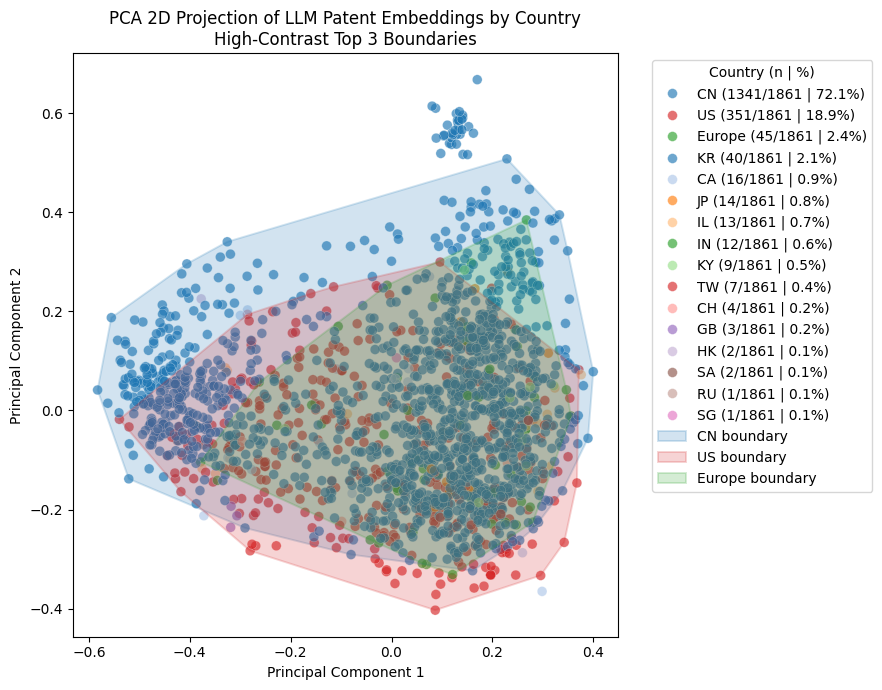

In [493]:
# ──────────── 셀 12-(10-1) 수정: PCA by Country with High-Contrast Top-3 Colors ────────────
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.spatial import ConvexHull
from sklearn.decomposition import PCA
from matplotlib.colors import to_rgb

EU_CODES = {
    "AT","BE","BG","HR","CY","CZ","DK","EE","FI","FR","DE","GR",
    "HU","IE","IT","LV","LT","LU","MT","NL","PL","PT","RO",
    "SK","SI","ES","SE"
}

# 1) Embeddings
cons_texts = df_conservative["fulltext"].tolist()
X_cons = encode_texts(cons_texts, batch_size=64)

# 2) PCA
pca_cons = PCA(n_components=2)
X2_cons = pca_cons.fit_transform(X_cons)

# 3) Country grouping
country_raw = df_conservative["country_code"].astype(str).fillna("UN").values
country_group = ["Europe" if c in EU_CODES else c for c in country_raw]

vis_cons = pd.DataFrame({
    "PC1": X2_cons[:, 0],
    "PC2": X2_cons[:, 1],
    "country_group": country_group
})

# 4) Counts & ordering
counts = vis_cons["country_group"].value_counts()
groups_ordered = counts.index.tolist()
top3 = groups_ordered[:3]

# 5) High-contrast colors for top3 (choose distinct hues)
top3_colors = {
    top3[0]: "#1f77b4",  # strong blue
    top3[1]: "#d62728",  # strong red
    top3[2]: "#2ca02c",  # strong green
}

# 6) Remaining colors (exclude those already used)
remaining_groups = [g for g in groups_ordered if g not in top3]
base_palette = sns.color_palette("tab20", len(remaining_groups))
remaining_color_map = {g: base_palette[i] for i, g in enumerate(remaining_groups)}

# 7) Merge color map
color_map = {**remaining_color_map, **top3_colors}

# 8) Scatter
plt.figure(figsize=(9, 7))
ax = sns.scatterplot(
    data=vis_cons,
    x="PC1", y="PC2",
    hue="country_group",
    hue_order=groups_ordered,
    palette=color_map,
    alpha=0.65,
    s=50,
    edgecolor="white",
    linewidth=0.3
)

# 9) Convex hull for top3 only
for grp in top3:
    pts = vis_cons.loc[vis_cons["country_group"] == grp, ["PC1", "PC2"]].values
    if pts.shape[0] >= 3:
        hull = ConvexHull(pts)
        hull_pts = pts[hull.vertices]
        ax.fill(
            hull_pts[:, 0], hull_pts[:, 1],
            alpha=0.20, facecolor=color_map[grp],
            edgecolor=color_map[grp], linewidth=1.4,
            label=f"{grp} boundary"
        )

# 10) Legend with ratios
ratios = (counts / counts.sum() * 100).round(1)
handles, labels = ax.get_legend_handles_labels()
label_map = {
    g: f"{g} ({counts[g]}/{counts.sum()} | {ratios[g]}%)"
    for g in groups_ordered
}
new_handles, new_labels, added = [], [], set()
for h, lab in zip(handles, labels):
    if lab in label_map and lab not in added:
        new_handles.append(h)
        new_labels.append(label_map[lab])
        added.add(lab)
    elif lab.endswith("boundary") and lab not in added:
        new_handles.append(h)
        new_labels.append(lab)
        added.add(lab)

ax.legend(
    new_handles, new_labels,
    title="Country (n | %)",
    bbox_to_anchor=(1.05, 1),
    loc="upper left"
)

plt.title("PCA 2D Projection of LLM Patent Embeddings by Country\nHigh-Contrast Top 3 Boundaries")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.tight_layout()
plt.show()


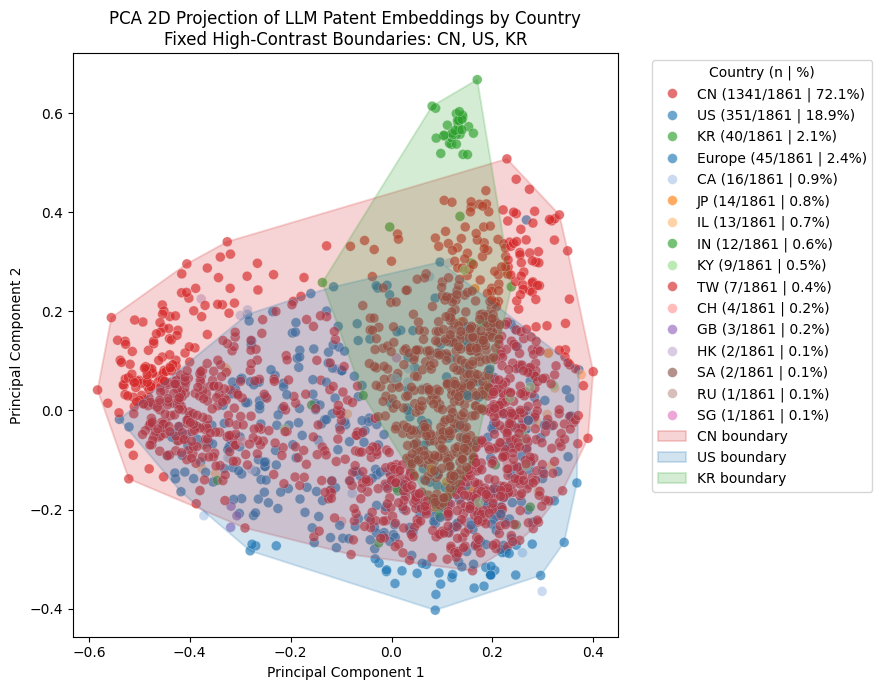

In [495]:
# ──────────── 셀 12-(10-1) 수정: PCA by Country with Fixed Top-3 (CN, US, KR) High Contrast ────────────
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.spatial import ConvexHull
from sklearn.decomposition import PCA

# 0) EU codes
EU_CODES = {
    "AT","BE","BG","HR","CY","CZ","DK","EE","FI","FR","DE","GR",
    "HU","IE","IT","LV","LT","LU","MT","NL","PL","PT","RO",
    "SK","SI","ES","SE"
}

# 1) Embeddings (reuse if existing)
cons_texts = df_conservative["fulltext"].tolist()
X_cons = encode_texts(cons_texts, batch_size=64)

# 2) PCA
pca_cons = PCA(n_components=2)
X2_cons = pca_cons.fit_transform(X_cons)

# 3) Country grouping
country_raw = df_conservative["country_code"].astype(str).fillna("UN").values
country_group = ["Europe" if c in EU_CODES else c for c in country_raw]

vis_cons = pd.DataFrame({
    "PC1": X2_cons[:, 0],
    "PC2": X2_cons[:, 1],
    "country_group": country_group
})

# 4) Fixed top3 countries
fixed_top3 = ["CN", "US", "KR"]

# 5) Counts & ordering (ensure fixed_top3 appear first if present)
counts = vis_cons["country_group"].value_counts()
# Preserve fixed_top3 order but only if they exist in data
present_top3 = [c for c in fixed_top3 if c in counts.index]
other_groups = [g for g in counts.index if g not in present_top3]
groups_ordered = present_top3 + other_groups

# 6) Color map: high contrast for CN, US, KR; palette for others
top3_colors = {
    "CN": "#d62728",  # vivid red
    "US": "#1f77b4",  # deep blue
    "KR": "#2ca02c",  # rich green
}
# Remaining palette
remaining_palette = sns.color_palette("tab20", len(other_groups))
remaining_color_map = {g: remaining_palette[i] for i, g in enumerate(other_groups)}
color_map = {**remaining_color_map, **{k: v for k, v in top3_colors.items() if k in present_top3}}

# 7) Scatter plot
plt.figure(figsize=(9, 7))
ax = sns.scatterplot(
    data=vis_cons,
    x="PC1", y="PC2",
    hue="country_group",
    hue_order=groups_ordered,
    palette=color_map,
    alpha=0.65,
    s=50,
    edgecolor="white",
    linewidth=0.3
)

# 8) Convex hull ONLY for present fixed top3
for grp in present_top3:
    pts = vis_cons.loc[vis_cons["country_group"] == grp, ["PC1", "PC2"]].values
    if pts.shape[0] >= 3:
        hull = ConvexHull(pts)
        hull_pts = pts[hull.vertices]
        ax.fill(
            hull_pts[:, 0], hull_pts[:, 1],
            alpha=0.20, facecolor=color_map[grp],
            edgecolor=color_map[grp], linewidth=1.4,
            label=f"{grp} boundary"
        )

# 9) Legend with ratios
ratios = (counts / counts.sum() * 100).round(1)
handles, labels = ax.get_legend_handles_labels()
label_map = {
    g: f"{g} ({counts[g]}/{counts.sum()} | {ratios[g]}%)"
    for g in groups_ordered
}

new_handles, new_labels, added = [], [], set()
for h, lab in zip(handles, labels):
    if lab in label_map and lab not in added:
        new_handles.append(h)
        new_labels.append(label_map[lab])
        added.add(lab)
    elif lab.endswith("boundary") and lab not in added:
        new_handles.append(h)
        new_labels.append(lab)
        added.add(lab)

ax.legend(
    new_handles, new_labels,
    title="Country (n | %)",
    bbox_to_anchor=(1.05, 1),
    loc="upper left"
)

plt.title("PCA 2D Projection of LLM Patent Embeddings by Country\nFixed High-Contrast Boundaries: CN, US, KR")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.tight_layout()
plt.show()


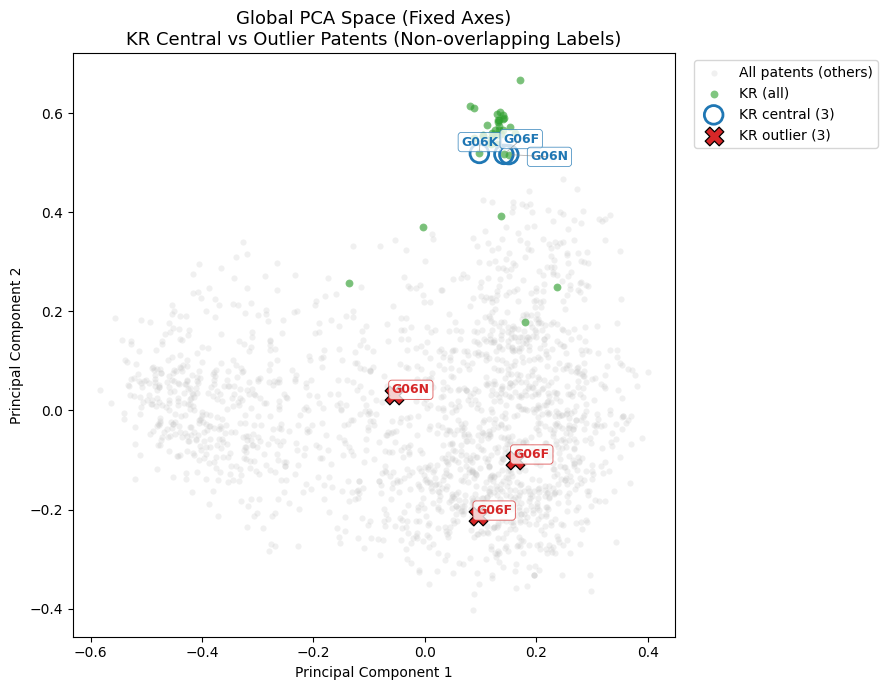

appl_id country_code cpc_main4         cpc_main  \
0  10-2014-0060332           KR      G06K  G06K-0009/00335   
1  10-2023-0036608           KR      G06F     G06F-0021/10   
2  10-2021-0113387           KR      G06N    G06N-0003/084   
3        17/207714           KR      G06N    G06N-0003/047   
4        13/869151           KR      G06F     G06F-0021/55   
5        14/796074           KR      G06F    G06F-0016/243   

                                               title category  
0                         사용자 그룹의 공간행동 센싱 및 의미분석 시스템  central  
1                  인공지능 알고리즘에 기초하여 초상권을 보호하는 방법 및 장치  central  
2                          딥러닝을 이용한 종교 감성 분석 장치 및 방법  central  
3           Method and system for recommending video  outlier  
4  Apparatus and method for detecting traffic flo...  outlier  
5  Method and system for searching for and provid...  outlier

In [502]:
# ──────────── 셀 12-(10-5) 개선: Non-overlapping Labels + Darker Background Gray ────────────
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from adjustText import adjust_text

# 전제: vis_cons (PC1, PC2, country_group), df_conservative, GLOBAL_XLIM/YLIM 존재
# 없다면 이전 셀에서 생성한 코드를 먼저 실행

kr_mask    = vis_cons["country_group"] == "KR"
kr_points  = vis_cons.loc[kr_mask, ["PC1","PC2"]].to_numpy()
kr_indices = vis_cons.index[kr_mask].to_numpy()

if kr_points.shape[0] < 6:
    print("KR samples < 6: cannot pick 3 central + 3 outlier.")
else:
    centroid = kr_points.mean(axis=0)
    dists = np.linalg.norm(kr_points - centroid, axis=1)

    central_sel  = np.argsort(dists)[:3]
    outlier_sel  = np.argsort(dists)[-3:]
    central_pts  = kr_points[central_sel]
    outlier_pts  = kr_points[outlier_sel]
    central_idx  = kr_indices[central_sel]
    outlier_idx  = kr_indices[outlier_sel]

    def get_cpc(idx):
        if "cpc_main4" in df_conservative.columns and pd.notna(df_conservative.loc[idx,"cpc_main4"]):
            return str(df_conservative.loc[idx,"cpc_main4"])
        if "cpc_main" in df_conservative.columns and pd.notna(df_conservative.loc[idx,"cpc_main"]):
            return str(df_conservative.loc[idx,"cpc_main"])
        return "CPC?"

    central_labels = [get_cpc(i) for i in central_idx]
    outlier_labels = [get_cpc(i) for i in outlier_idx]

    plt.figure(figsize=(9,7))

    # (a) All patents (background) - slightly darker gray
    plt.scatter(
        vis_cons["PC1"], vis_cons["PC2"],
        c="#BFBFBF", s=20, alpha=0.22, linewidths=0, label="All patents (others)"
    )

    # (b) KR all
    plt.scatter(
        kr_points[:,0], kr_points[:,1],
        c="#2ca02c", s=32, alpha=0.6, linewidths=0, label="KR (all)"
    )

    # (c) KR central 3
    plt.scatter(
        central_pts[:,0], central_pts[:,1],
        s=180, facecolors="none", edgecolors="#1f77b4", linewidths=2.0,
        label="KR central (3)"
    )

    # (d) KR outlier 3
    plt.scatter(
        outlier_pts[:,0], outlier_pts[:,1],
        s=180, marker="X", c="#d62728", edgecolors="black", linewidths=0.9,
        label="KR outlier (3)"
    )

    # Prepare label texts for adjustText
    texts = []

    # Central labels
    for (x,y), lab in zip(central_pts, central_labels):
        texts.append(
            plt.text(
                x, y, lab,
                fontsize=9, weight='bold', color="#1f77b4",
                bbox=dict(boxstyle="round,pad=0.25", fc="white", alpha=0.78,
                          lw=0.6, ec="#1f77b4")
            )
        )

    # Outlier labels
    for (x,y), lab in zip(outlier_pts, outlier_labels):
        texts.append(
            plt.text(
                x, y, lab,
                fontsize=9, weight='bold', color="#d62728",
                bbox=dict(boxstyle="round,pad=0.25", fc="white", alpha=0.78,
                          lw=0.6, ec="#d62728")
            )
        )

    # Adjust to prevent overlap (moves labels + draws optional arrows)
    adjust_text(
        texts,
        expand_points=(1.2, 1.2),
        expand_text=(1.2, 1.2),
        force_text=(0.5, 0.5),
        lim=200,
        arrowprops=dict(arrowstyle='-', color='gray', lw=0.6, alpha=0.6)
    )

    plt.xlim(GLOBAL_XLIM); plt.ylim(GLOBAL_YLIM)
    plt.title("Global PCA Space (Fixed Axes)\nKR Central vs Outlier Patents (Non-overlapping Labels)", fontsize=13)
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")

    handles, labels = plt.gca().get_legend_handles_labels()
    uniq = dict(zip(labels, handles))
    plt.legend(uniq.values(), uniq.keys(), loc="upper left", bbox_to_anchor=(1.02,1))

    plt.tight_layout()
    plt.show()

    # Summary table
    summary_cols = ["appl_id","country_code"]
    extra_cols = [c for c in ["cpc_main4","cpc_main","title"] if c in df_conservative.columns]
    chosen_idx = np.concatenate([central_idx, outlier_idx])
    summary_df = df_conservative.loc[chosen_idx, summary_cols + extra_cols].copy()
    summary_df["category"] = ["central"]*3 + ["outlier"]*3
    cat_order = pd.Categorical(summary_df["category"], categories=["central","outlier"], ordered=True)
    summary_df = summary_df.assign(_cat=cat_order).sort_values("_cat").drop(columns="_cat").reset_index(drop=True)

    display(summary_df)


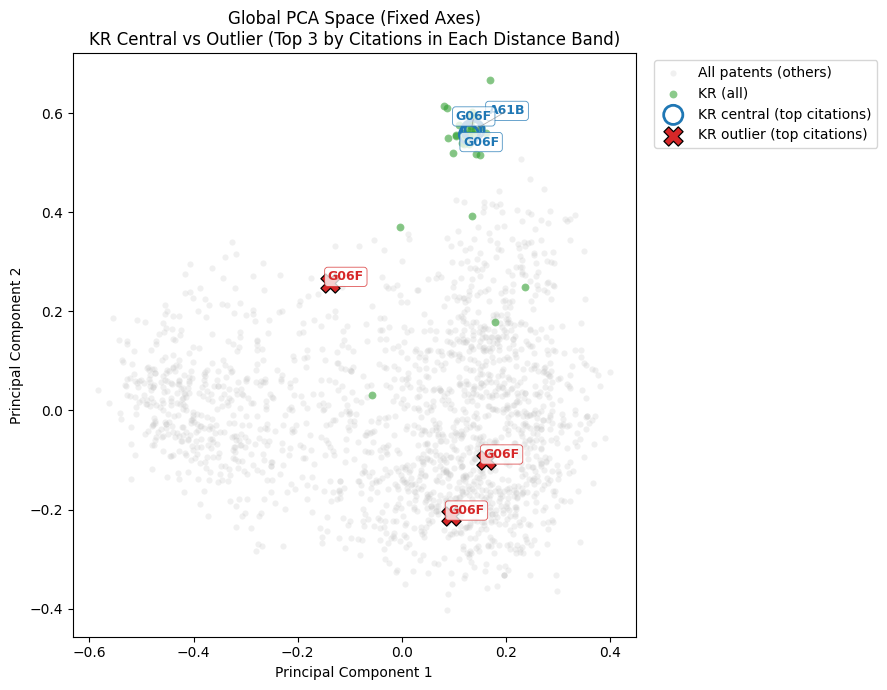

appl_id country_code  cited_by_count cpc_main4        cpc_main  \
0  10-2013-0089058           KR              18      G06F  G06F-0017/2785   
1  10-2019-0108607           KR              12      A61B   A61B-0005/165   
2  10-2011-0123625           KR               7      G06F   G06F-0016/156   
3        16/485421           KR              21      G06F    G06F-0040/30   
4        13/869151           KR              14      G06F    G06F-0021/55   
5        14/796074           KR              11      G06F   G06F-0016/243   

                                               title category  
0                         단어 패턴을 이용한 카테고리 및 감성 분석시스템  central  
1            신경망 기반 감정 분석 방법 및 장치, 및 그에 기반한 감정 치료 장치  central  
2    인터넷을 활용한 개체 검색과 이를 위한 하이브리드 기반의 의견분석 시스템 및 그 방법  central  
3  Emotion classification information-based text-...  outlier  
4  Apparatus and method for detecting traffic flo...  outlier  
5  Method and system for searching for and provid...  outlier

In [503]:
# ──────────── 셀 12-(10-5-REV): KR Central / Outlier by Distance, Top-3 Each by cited_by_count ────────────
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from adjustText import adjust_text

# 전제: vis_cons (PC1, PC2, country_group), df_conservative, GLOBAL_XLIM/YLIM 존재
# KR 추출
kr_mask    = vis_cons["country_group"] == "KR"
kr_points  = vis_cons.loc[kr_mask, ["PC1","PC2"]].to_numpy()
kr_indices = vis_cons.index[kr_mask].to_numpy()

if kr_points.shape[0] < 6:
    print("KR samples < 6: cannot pick central/outlier 3 each.")
else:
    # 1) 중심 및 거리
    centroid = kr_points.mean(axis=0)
    dists = np.linalg.norm(kr_points - centroid, axis=1)

    # 2) 거리 기준으로 절반 split (중앙/아웃라이어 후보 집합)
    #    - 중앙 후보: 하위 50% 거리
    #    - 아웃라이어 후보: 상위 50% 거리
    median_dist = np.median(dists)
    central_candidate_mask  = dists <= median_dist
    outlier_candidate_mask  = dists >  median_dist

    central_candidate_idx = kr_indices[central_candidate_mask]
    outlier_candidate_idx = kr_indices[outlier_candidate_mask]

    # 안전장치: 후보가 3개 미만이면 보정 (부족하면 거리 순으로 보충)
    if central_candidate_idx.shape[0] < 3:
        needed = 3 - central_candidate_idx.shape[0]
        # 가장 가까운 순에서 아직 선택 안 된 것 추가
        additional = kr_indices[np.argsort(dists)][:needed]
        central_candidate_idx = np.unique(np.concatenate([central_candidate_idx, additional]))
    if outlier_candidate_idx.shape[0] < 3:
        needed = 3 - outlier_candidate_idx.shape[0]
        additional = kr_indices[np.argsort(-dists)][:needed]
        outlier_candidate_idx = np.unique(np.concatenate([outlier_candidate_idx, additional]))

    # 3) 각 후보 집합에서 cited_by_count 상위 3개 선발
    def top_by_citations(idxs, topk=3):
        sub = df_conservative.loc[idxs, ["cited_by_count"]]
        # 정렬 (내림차순), 인용 동률 시 appl_id 알파벳/숫자 순
        order = sub.sort_values(["cited_by_count"], ascending=[False]).index.to_numpy()
        return order[:topk]

    central_idx  = top_by_citations(central_candidate_idx, 3)
    outlier_idx  = top_by_citations(outlier_candidate_idx, 3)

    # 4) 좌표 및 라벨 정보
    central_pts = vis_cons.loc[central_idx, ["PC1","PC2"]].to_numpy()
    outlier_pts = vis_cons.loc[outlier_idx, ["PC1","PC2"]].to_numpy()

    def get_cpc(idx):
        if "cpc_main4" in df_conservative.columns and pd.notna(df_conservative.loc[idx,"cpc_main4"]):
            return str(df_conservative.loc[idx,"cpc_main4"])
        if "cpc_main"   in df_conservative.columns and pd.notna(df_conservative.loc[idx,"cpc_main"]):
            return str(df_conservative.loc[idx,"cpc_main"])
        return "CPC?"

    central_labels = [get_cpc(i) for i in central_idx]
    outlier_labels = [get_cpc(i) for i in outlier_idx]

    # 5) 시각화
    plt.figure(figsize=(9,7))
    # 배경 전체 (옅은 회색)
    plt.scatter(
        vis_cons["PC1"], vis_cons["PC2"],
        c="#BFBFBF", s=20, alpha=0.22, linewidths=0, label="All patents (others)"
    )
    # KR 전체
    plt.scatter(
        vis_cons.loc[kr_mask,"PC1"], vis_cons.loc[kr_mask,"PC2"],
        c="#2ca02c", s=32, alpha=0.55, linewidths=0, label="KR (all)"
    )
    # 중앙 3
    plt.scatter(
        central_pts[:,0], central_pts[:,1],
        s=190, facecolors="none", edgecolors="#1f77b4", linewidths=2.0,
        label="KR central (top citations)"
    )
    # 아웃라이어 3
    plt.scatter(
        outlier_pts[:,0], outlier_pts[:,1],
        s=190, marker="X", c="#d62728", edgecolors="black", linewidths=0.9,
        label="KR outlier (top citations)"
    )

    # 라벨 (adjustText로 겹침 방지)
    texts = []
    for (x,y), lab in zip(central_pts, central_labels):
        texts.append(
            plt.text(
                x, y, lab,
                fontsize=9, weight='bold', color="#1f77b4",
                bbox=dict(boxstyle="round,pad=0.25", fc="white", alpha=0.78,
                          lw=0.6, ec="#1f77b4")
            )
        )
    for (x,y), lab in zip(outlier_pts, outlier_labels):
        texts.append(
            plt.text(
                x, y, lab,
                fontsize=9, weight='bold', color="#d62728",
                bbox=dict(boxstyle="round,pad=0.25", fc="white", alpha=0.78,
                          lw=0.6, ec="#d62728")
            )
        )

    adjust_text(
        texts,
        expand_points=(1.2,1.2),
        expand_text=(1.2,1.2),
        force_text=(0.5,0.5),
        lim=200,
        arrowprops=dict(arrowstyle='-', color='gray', lw=0.6, alpha=0.6)
    )

    # 글로벌 축 적용
    plt.xlim(GLOBAL_XLIM); plt.ylim(GLOBAL_YLIM)
    plt.title("Global PCA Space (Fixed Axes)\nKR Central vs Outlier (Top 3 by Citations in Each Distance Band)")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")

    # Legend (중복 제거)
    handles, labels = plt.gca().get_legend_handles_labels()
    uniq = dict(zip(labels, handles))
    plt.legend(uniq.values(), uniq.keys(), loc="upper left", bbox_to_anchor=(1.02,1))
    plt.tight_layout()
    plt.show()

    # 6) 요약 표
    summary_cols = ["appl_id","country_code","cited_by_count"]
    extra_cols = [c for c in ["cpc_main4","cpc_main","title"] if c in df_conservative.columns]
    combined_idx = np.concatenate([central_idx, outlier_idx])
    summary_df = df_conservative.loc[combined_idx, summary_cols + extra_cols].copy()
    summary_df["category"] = ["central"]*len(central_idx) + ["outlier"]*len(outlier_idx)
    # 정렬: category, cited_by_count desc
    cat_order = pd.Categorical(summary_df["category"], categories=["central","outlier"], ordered=True)
    summary_df = (summary_df
                  .assign(_cat=cat_order)
                  .sort_values(["_cat","cited_by_count"], ascending=[True,False])
                  .drop(columns="_cat")
                  .reset_index(drop=True))
    display(summary_df)
